<a href="https://colab.research.google.com/github/austinpeel/jax-strong-lensing/blob/dev-egor/jaxified_GRF_fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Folder='/content/drive/My Drive/Jax_Strong_Lensing/'

import sys
sys.path.append(Folder+'/Modules')
_=!python drive/My\ Drive/Jax_Strong_Lensing/Modules/My_repo/setup.py install

Mounted at /content/drive


In [2]:
_=!pip install pyFFTW
_=!pip install powerbox

In [3]:
# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline


# Basic imports
import numpy as np
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
import math

#JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

#Optimizer
from jax.scipy.optimize import minimize as jax_minimize
def get_hashable_MSE(True_array):
  def MSE(Fit_array):
    return jnp.mean(jnp.power(Fit_array-True_array,2))

  return jax.tree_util.Partial(MSE)

'''
@jax.partial(jax.jit,static_argnums=(1,2,3,4))
def Loss_GRF_potential(params,loss,seed,npix,pix_scl):
  A,beta=params
  GRF=get_jaxified_GRF([A,beta],seed,npix,pix_scl)
  return loss(GRF)

x0=np.array([1e-8,3.])
res=jax_minimize(Loss_GRF_potential,x0,args=(get_hashable_MSE(GRF_realisation),GRF_seed,npix,pix_scl),method='BFGS')
'''


#Jaxtronomy
from jaxtronomy.Coordinates.pixel_grid import PixelGrid
from jaxtronomy.Instrument.psf import PSF
from jaxtronomy.Instrument.noise import Noise
from jaxtronomy.LightModel.light_model import LightModel
from jaxtronomy.LensModel.lens_model import LensModel
from jaxtronomy.LensImage.lens_image import LensImage
from jaxtronomy.Parameters.parameters import Parameters
from jaxtronomy.Inference.loss import Loss
from jaxtronomy.Inference.optimization import Optimizer


#GRF generator
import powerbox as pbox

#My utils
from jaxtronomy.GaussianRandomField.GRF_model import Potential_based_GRF_perturbed_lens
from jaxtronomy.GaussianRandomField.GRF_model import GRF_perturbed_lens
from jaxtronomy.GaussianRandomField.Lens_Source_model import Lens_Source_model

#Jaxified GRF generator
from jaxtronomy.GaussianRandomField.PowerBox_jaxified import get_jaxified_GRF 




# Universal font size
FS = 18

## Data grids

In [4]:
npix = 100
pix_scl = 0.08  # arcsec / pixel
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2
transform_pix2angle = pix_scl * np.eye(2)
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}
pixel_grid = PixelGrid(**kwargs_pixel)
xgrid, ygrid = pixel_grid.pixel_coordinates
x_coords = xgrid[0, :]
y_coords = ygrid[:, 0]

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {xgrid[0, 0], xgrid[0, -1]} arcsec")
print(f"y range    : {ygrid[0, 0], ygrid[-1, 0]} arcsec")

image size : (100, 100) pixels
pixel size : 0.08 arcsec
x range    : (-3.96, 3.96) arcsec
y range    : (-3.96, 3.96) arcsec


## Source light model

In [5]:
source_light_model_list = ['SERSIC_ELLIPSE']
source_light_model = LightModel(source_light_model_list)
kwargs_source_light = [{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'center_x': 0.4, 'center_y': 0.15,'e1':0.07,'e2':-0.1}]

## Lens model (SIE + external shear)

In [6]:
#Seed=0 is treated like abscence of seed. Use 1 or more
def get_GRF_potential(A,beta,npix=npix,pix_scl=pix_scl,seed=1):

    #2*pi*number_pix*pix_scale
    box_length = 2 * np.pi * npix * pix_scl
    return pbox.PowerBox(N=npix, dim=2, pk=(lambda k: A * k**(-beta)), boxlength=box_length, seed=seed,vol_normalised_power=False).delta_x()

In [7]:
# Lens mass
lens_mass_model_list = ['SIE', 'SHEAR','PIXELATED']
lens_mass_model = LensModel(lens_mass_model_list)

GRF_Amp=1e-7
GRF_beta=2.
GRF_seed=1
GRF_realisation=deepcopy(get_GRF_potential(GRF_Amp,GRF_beta,seed=GRF_seed))
kwargs_lens_mass = [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},\
                    {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0.0, 'dec_0': 0.0},\
                    {'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': GRF_realisation}]

# Lens light
lens_light_model_list = []
lens_light_model = LightModel(lens_light_model_list)
kwargs_lens_light = [{}]

## Observation conditions

In [8]:
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': 0.3}
psf = PSF(**kwargs_psf)

exp_time = 2028
SNR=100

In [9]:
#SNR-defined noise
kwargs_numerics = {'supersampling_factor': 1}
lens_image = LensImage(pixel_grid, psf, noise_class={'background_rms': np.zeros((npix, npix)), 'exposure_time': exp_time},
                         lens_model_class=lens_mass_model,
                         source_model_class=source_light_model,
                         lens_light_model_class=lens_light_model,
                         kwargs_numerics=kwargs_numerics)

image=lens_image.model(kwargs_lens=kwargs_lens_mass,
                          kwargs_source=kwargs_source_light,
                          kwargs_lens_light=kwargs_lens_light)

Peak_signal=np.abs(image).max()
sigma_bkd = Peak_signal/SNR
noise_map = sigma_bkd * np.ones((npix, npix))
noise = Noise(npix, npix, **{'background_rms': sigma_bkd, 'exposure_time': exp_time})

## Image model

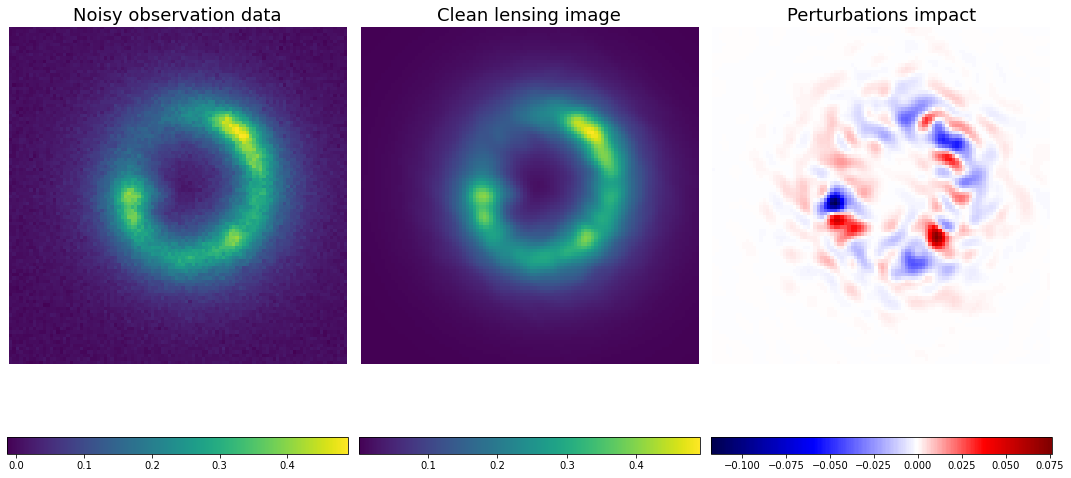

In [10]:
# Generate a lensed image based on source and lens models
kwargs_numerics = {'supersampling_factor': 1}
lens_image = LensImage(pixel_grid, psf, noise_class=noise,
                         lens_model_class=lens_mass_model,
                         source_model_class=source_light_model,
                         lens_light_model_class=lens_light_model,
                         kwargs_numerics=kwargs_numerics)

image = lens_image.model(kwargs_lens=kwargs_lens_mass,
                          kwargs_source=kwargs_source_light,
                          kwargs_lens_light=kwargs_lens_light)

true_source = lens_image.source_surface_brightness(kwargs_source=kwargs_source_light, 
                                                   de_lensed=True, unconvolved=True)

# Observed noisy data
data = lens_image.simulation(kwargs_lens=kwargs_lens_mass,
                              kwargs_source=kwargs_source_light,
                              kwargs_lens_light=kwargs_lens_light)

# Plot
fig, ax = plt.subplots(1, 3, figsize=(15, 7))

im0=ax[0].imshow(data, origin='lower')
ax[0].set_title("Noisy observation data", fontsize=FS)


im1=ax[1].imshow(image, origin='lower')
ax[1].set_title("Clean lensing image", fontsize=FS)

smooth_lens_image_class=LensImage(data_class=pixel_grid,
                         psf_class=psf,
                         noise_class=noise,
                         lens_model_class=LensModel(lens_mass_model_list[:-1]),
                         source_model_class=source_light_model,
                         lens_light_model_class=LightModel([]),
                         kwargs_numerics={'supersampling_factor': 1})

smooth_lens_image=smooth_lens_image_class.model(kwargs_lens=kwargs_lens_mass[:-1],
                                                kwargs_source=kwargs_source_light,
                                                kwargs_lens_light=kwargs_lens_light)


resid_true=image-smooth_lens_image
im2=ax[2].imshow(resid_true, origin='lower',cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
ax[2].set_title("Perturbations impact", fontsize=FS)

for i,img in enumerate([im0,im1, im2]):
    ax[i].axis('off')
    fig.colorbar(img, ax=ax[i],orientation='horizontal')

fig.tight_layout()

## Mask

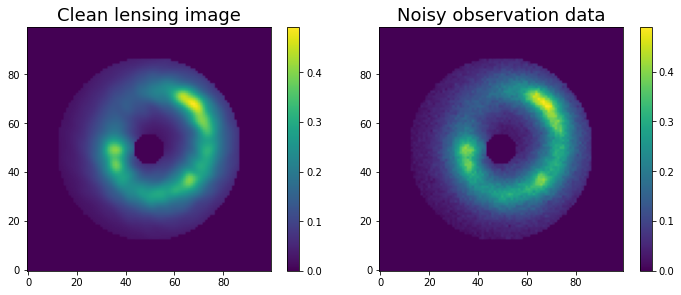

In [11]:
rmin = 0.5
rmax = 3
radius = np.hypot(xgrid, ygrid)
#Mask covering Einstein ring
mask = ((radius >= rmin) & (radius <= rmax)).astype(bool)

#Account for frequencies present according to size of masked region 
k=np.fft.fftshift(np.fft.fftfreq(npix,pix_scl))[npix//2:]
mask_spectral_cut_index=np.where(k>1/(rmax-rmin))[0][0]
masked_k=k[mask_spectral_cut_index:]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
img1 = ax1.imshow(image*mask, origin='lower')
ax1.set_title("Clean lensing image", fontsize=FS)
img2 = ax2.imshow(data*mask, origin='lower')
ax2.set_title("Noisy observation data", fontsize=FS)
for img, ax in zip((img1, img2), (ax1, ax2)):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

# Non-Jaxified fitting

In [12]:
def get_parameters(kwargs):

  kwargs_model = {
    'lens_model_list': lens_mass_model_list[:-1],
    'source_model_list': source_light_model_list,
    'lens_light_model_list': [],
  }

  kwargs_init = {
    'kwargs_lens': kwargs['kwargs_lens'],
    'kwargs_source': kwargs['kwargs_source'],
  }


  #Priors from this article Park et al. 2021 Table 1 (Partially)
  '''
  kwargs_prior = {
    'kwargs_lens': [{'theta_E': ['gaussian', 1.1, 0.1], 'e1': ['gaussian', 0, 0.2], 'e2': ['gaussian', 0, 0.2], \
                     'center_x': ['gaussian', 0, 0.07], 'center_y': ['gaussian', 0, 0.07]}, {'gamma1': ['uniform', -0.05, 0.05], 'gamma2': ['uniform', -0.05, 0.05]}],
                  
    'kwargs_source': [{'amp': ['uniform',5.0,20.0], 'R_sersic': ['uniform',1e-3,5.], 'n_sersic': ['gaussian',3,0.5],\
                       'center_x': ['uniform', -1.0, 1.0], 'center_y': ['uniform', -1.0, 1.0],'e1': ['gaussian', 0, 0.2], 'e2': ['gaussian', 0, 0.2]}],
  }
  '''

  kwargs_prior = {
    'kwargs_lens': [{'theta_E': ['uniform', 1., 2.], 'e1': ['gaussian', 0, 0.2], 'e2': ['gaussian', 0, 0.2], \
                     'center_x': ['gaussian', 0, 0.102], 'center_y': ['gaussian', 0, 0.102]}, {'gamma1': ['uniform', -0.5, 0.5], 'gamma2': ['uniform', -0.5, 0.5]}],
                  
    'kwargs_source': [{'amp': ['uniform',5.0,20.0], 'R_sersic': ['uniform',1e-3,5.], 'n_sersic': ['uniform',1e-3,4.0],\
                       'center_x': ['uniform', -1.0, 1.0], 'center_y': ['uniform', -1.0, 1.0],'e1': ['gaussian', 0, 0.2], 'e2': ['gaussian', 0, 0.2]}],
  }
  
  kwargs_fixed = {
    'kwargs_lens': [{}, {'ra_0': 0., 'dec_0': 0.}],  # fix origin of the external shear profile
    'kwargs_source': [{}],  # fix all source parameters
    }

  parameters = Parameters(kwargs_model, kwargs_init, kwargs_prior, kwargs_fixed)

  return parameters

In [13]:
def get_model(kwargs):


  # Generate a lensed image based on source and lens models
  #Source light from simulation
  #Lens mass except for PIXELATED GRF from simulation
  lens_image = LensImage(data_class=pixel_grid,
                         psf_class=psf,
                         noise_class=noise,
                         lens_model_class=LensModel(lens_mass_model_list[:-1]),
                         source_model_class=source_light_model,
                         lens_light_model_class=LightModel([]),
                         kwargs_numerics={'supersampling_factor': 1})
  
  #To calculate noise map for the first time
  '''
  _= lens_image.simulation(compute_true_noise_map=True,
                             kwargs_lens=kwargs['kwargs_lens'],
                             kwargs_source=kwargs['kwargs_source'],
                             kwargs_lens_light=kwargs['kwargs_lens_light'])
  '''

  kwargs_true = {'kwargs_lens': kwargs_lens_mass[:-1], 'kwargs_source': kwargs_source_light}

  return lens_image,kwargs_true

In [14]:
def fit_data(data,lens_image,parameters):

  parameters=deepcopy(parameters)

  loss = Loss(data, lens_image, parameters)
  grad_loss = jax.jit(jax.grad(loss))

  optimizer = Optimizer(loss, parameters)
  #BFGS for gradient only, Newton-CG for graident+ hessian vector product
  #BFGS is faster since it doesn't compute hessian vp
  best_fit, logL, extra_fields, runtime \
    = optimizer.minimize(method='BFGS', restart_from_init=True,
                         use_exact_hessian_if_allowed=False)
    
  kwargs_final = deepcopy(parameters.ML_values(as_kwargs=True))
  if extra_fields['hess_inv'] is not None:
    fisher_matrix = extra_fields['hess_inv']
  else:
    hess_ml = optimizer.hessian(best_fit)
    fisher_matrix = jax.numpy.linalg.inv(hess_ml)

  return parameters.kwargs2args(kwargs_final),fisher_matrix

In [15]:
def Radial_profile(image,q=1,x0=None,y0=None,phi=0):
    x0=image.shape[1]/2
    y0=image.shape[0]/2


    R_max=image.shape[0]//2
    radial_profile=np.zeros(R_max)
    counter=np.zeros(R_max)
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            R=np.sqrt(np.power(x-x0,2)+np.power(y-y0,2))
            #Account only unmasked values 
            if (R<R_max):
                radial_profile[int(R)]+=image[y,x]
                counter[int(R)]+=1

    radial_profile=radial_profile/counter
    #radial_profile[mask_nan]=0

    #Radial profile is average Flux in a ring of radius R
    return radial_profile

def compute_radial_spetrum(image,pix_scl=pix_scl,mask=mask):
  #Scales larger than the size of the masked region (Einstein ring)
  masked_image=image*mask

  spectrum=np.fft.fft2(masked_image)
  half_im_size=image.shape[0]//2
  Centered_Spectrum=np.roll(np.abs(spectrum)**2,half_im_size,axis=(0,1))
  
  return Radial_profile(Centered_Spectrum)[mask_spectral_cut_index:]

In [16]:
def external_mean_SE(data,fit_samples,Poisson_err=False):
  if Poisson_err:
    return np.nanmean(np.power((data-fit_samples)/fit_samples,2),axis=(0,-1))
  else:
    return np.nanmean(np.power((data-fit_samples),2),axis=(0,-1))

### First fit

In [17]:
kwargs_true={'kwargs_lens':kwargs_lens_mass[:-1],'kwargs_lens_light':kwargs_lens_light,'kwargs_source':kwargs_source_light}

In [18]:
smooth_lens_image,_=get_model(kwargs_true)
parameters=get_parameters(kwargs_true)
args0,fisher_matrix0=fit_data(image,smooth_lens_image,parameters)

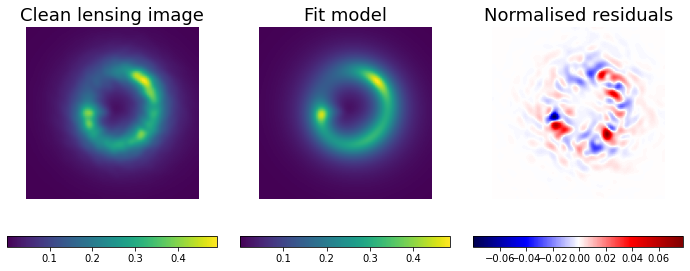

In [19]:
kwargs0=parameters.args2kwargs(args0)
model0=smooth_lens_image.model(kwargs_lens=kwargs0['kwargs_lens'],
                          kwargs_source=kwargs0['kwargs_source'],
                          kwargs_lens_light=kwargs0['kwargs_lens_light'])

# Plot
fig, ax = plt.subplots(1, 3, figsize=(10, 4))
im0=ax[0].imshow(image, origin='lower')
ax[0].set_title("Clean lensing image", fontsize=FS)

im1=ax[1].imshow(model0, origin='lower')
ax[1].set_title("Fit model", fontsize=FS)

resid0=(image-model0)
im2=ax[2].imshow(resid0,origin='lower',cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
ax[2].set_title("Normalised residuals", fontsize=FS)


for i,img in enumerate([im0,im1, im2]):
    ax[i].axis('off')
    fig.colorbar(img, ax=ax[i],orientation='horizontal')

fig.tight_layout()
plt.show()

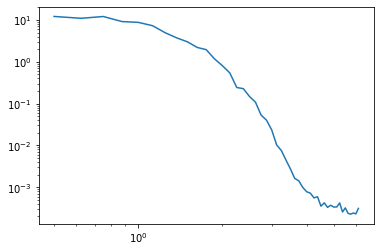

In [20]:
resid0_spectrum=compute_radial_spetrum(resid0)
plt.loglog(masked_k,resid0_spectrum)

## Jaxified simulation and second fit

### Optimization example

In [21]:
def purify_function(function,*static_args):
    def pure_function(traced_arg):
      return function(traced_arg,*static_args)
    return jax.jit(pure_function)

def array_getter(array):
    def getter():
      return array
    return jax.jit(getter)

In [22]:
def get_hashable_MSE(True_array):
  def MSE(Fit_array):
    return jnp.mean(jnp.power(Fit_array-True_array,2))

  return jax.tree_util.Partial(MSE)

In [23]:
def MSE(model,data):
  return jnp.mean(jnp.power(data-model,2))

In [24]:
MSE_pure=purify_function(MSE,GRF_realisation)

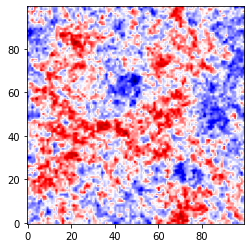

In [25]:
#MSE=get_hashable_MSE(GRF_realisation)


plt.imshow(GRF_realisation,origin='lower',cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))

In [26]:
@jax.partial(jax.jit,static_argnums=(1,2,3,4))
def Loss_GRF_potential(params,loss,seed,npix,pix_scl):
  A,beta=params
  GRF=get_jaxified_GRF([A,beta],seed,npix,pix_scl)
  return loss(GRF)

In [27]:
MSE_pure=purify_function(MSE,GRF_realisation)
x0=np.array([1e-8,3.])
res=jax_minimize(Loss_GRF_potential,x0,args=(MSE_pure,GRF_seed,npix,pix_scl),method='BFGS')

KeyboardInterrupt: ignored

In [ ]:
res

OptimizeResults(x=DeviceArray([9.99999999e-08, 2.00000000e+00], dtype=float64), success=DeviceArray(True, dtype=bool), status=DeviceArray(0, dtype=int64), fun=DeviceArray(3.63325933e-23, dtype=float64), jac=DeviceArray([-7.43277171e-07, -8.50053434e-15], dtype=float64), hess_inv=DeviceArray([[1.30217758e-10, 1.05909221e-05],
             [1.05909221e-05, 9.84740115e+03]], dtype=float64), nfev=DeviceArray(43, dtype=int64), njev=DeviceArray(43, dtype=int64), nit=DeviceArray(30, dtype=int64))

### Jaxified radial profile

In [28]:
def Radial_profile(image,image_shape):
  size_y,size_x=image_shape
  min_size=np.minimum(size_y,size_x)

  x=np.arange(size_x)-size_x/2+0.5
  y=np.arange(size_y)-size_y/2+0.5
  X,Y=np.meshgrid(x,y)

  #Matrix of radii
  R=np.sqrt(np.power(X,2)+np.power(Y,2))
  radius_size=math.ceil(min_size/2)
  R_mask_tensor=np.zeros((radius_size,size_y,size_x))

  for i in range(radius_size):
      #Chose ring of given radius
      condition=(R>=i) & (R<i+1)
      R_mask_tensor[i]=np.where(condition,1,0)

  #Number of pixels on given radius
  pixel_counter=R_mask_tensor.sum(axis=(1,2))

  #Summary flux in ring with given radius
  sum_in_rings=(image*R_mask_tensor).sum(axis=(1,2))

  #Average flux in ring with given radius
  radial_profile=sum_in_rings/pixel_counter

  return radial_profile

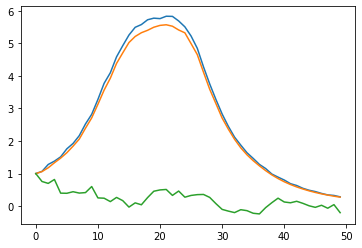

In [ ]:
Radial_profile_pure=purify_function(Radial_profile,(npix,npix))

images_to_rp=[data,image,GRF_realisation]
for i in range(3):
  rp=Radial_profile_pure(images_to_rp[i])
  rp/=rp[0]
  plt.plot(rp)

Text(0.5, 1.0, 'Gradients of mean(Radial_profile)')

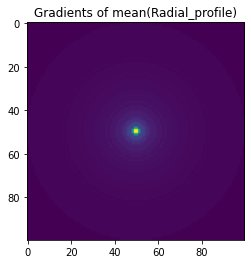

In [ ]:
@jax.partial(jax.jit,static_argnums=1)
def test_func(image,Radial_profile_pure):
    return jnp.mean(Radial_profile_pure(image))

grads=jax.grad(test_func)(image,Radial_profile_pure)
plt.imshow(grads)
plt.title('Gradients of mean(Radial_profile)')

### Jaxified power spectrum

In [29]:
def compute_radial_spectrum(image,Radial_profile,mask,mask_spectral_cut_index):
  #Mask should be the same shape as image
  #it should be square
  assert mask.shape[0]==mask.shape[1]

  #Leave only region with Einstein ring
  masked_image=image*mask

  spectrum=jnp.abs(jnp.fft.fft2(masked_image))**2
  shift=mask.shape[0]//2
  Centered_Spectrum=jnp.roll(spectrum,shift,axis=(0,1))

  Radially_avg_spectrum=Radial_profile(Centered_Spectrum,mask.shape)

  return Radially_avg_spectrum[mask_spectral_cut_index:]

In [ ]:
mask_spectral_cut_index

4

In [ ]:
compute_radial_spectrum(resid0,Radial_profile,mask,0)

DeviceArray([2.75495046e+00, 7.38967978e+00, 9.19915373e+00,
             1.17016538e+01, 1.23753751e+01, 1.02814510e+01,
             1.08271863e+01, 1.01397750e+01, 8.52667214e+00,
             6.16787733e+00, 4.68118385e+00, 3.66995378e+00,
             2.70637337e+00, 2.12230646e+00, 1.75642651e+00,
             1.21498602e+00, 7.79100718e-01, 4.74535952e-01,
             2.64080839e-01, 2.03642121e-01, 1.43516387e-01,
             9.91697875e-02, 5.99039740e-02, 3.63061404e-02,
             2.17399878e-02, 1.10666865e-02, 7.00144995e-03,
             4.53056434e-03, 2.65300414e-03, 1.67648188e-03,
             1.32474635e-03, 9.32331301e-04, 8.81026460e-04,
             5.77380695e-04, 6.23651205e-04, 5.22850705e-04,
             4.18229524e-04, 3.82116744e-04, 3.36771428e-04,
             4.01521375e-04, 3.07726278e-04, 3.83465787e-04,
             3.51114215e-04, 2.96592472e-04, 2.93895625e-04,
             2.29344483e-04, 2.52486262e-04, 2.22349420e-04,
             2.76255477e

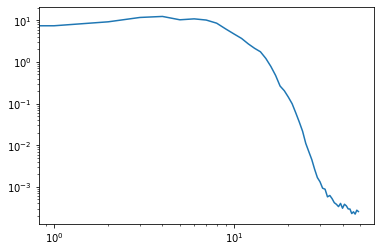

In [ ]:
q=np.ones((5,5))
spectrum=compute_radial_spectrum(resid0,Radial_profile,mask,0)
plt.loglog(spectrum)

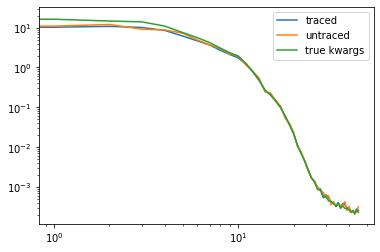

In [31]:
compute_radial_spectrum_pure=purify_function(compute_radial_spectrum,Radial_profile,mask,mask_spectral_cut_index)
spectrum=compute_radial_spectrum_pure(resid0)
resid_true_spectrum=compute_radial_spectrum_pure(resid_true)
plt.loglog(spectrum,label='traced')
plt.loglog(resid0_spectrum,label='untraced')
plt.loglog(resid_true_spectrum,label='true kwargs')
plt.legend()
plt.show()

 difference probably because I used wrong indexing in Radial profile

In [ ]:
@jax.partial(jax.jit,static_argnums=(1))
def test_func(image,compute_radial_spectrum_pure):
    return jnp.mean(compute_radial_spectrum_pure(image))

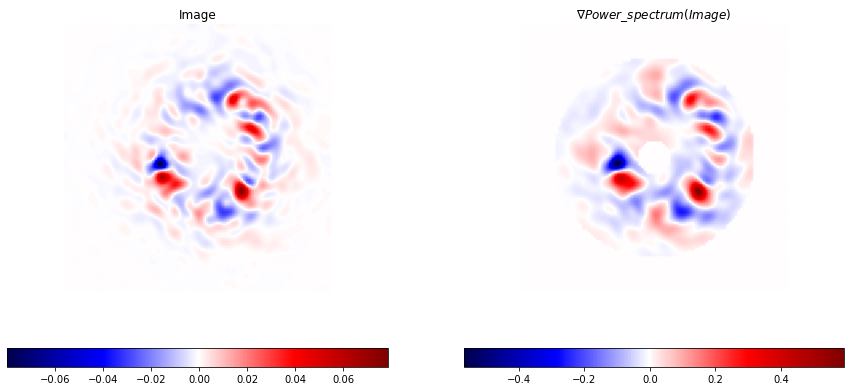

In [ ]:
spec_grad=jax.grad(test_func)(resid0,compute_radial_spectrum_pure)
fig,ax=plt.subplots(1,2,figsize=(15,7))

im0=ax[0].imshow(resid0,origin='lower',cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
ax[0].set_title('Image')

im1=ax[1].imshow(spec_grad,origin='lower',cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
ax[1].set_title(r'$\nabla Power\_spectrum(Image)$')

for i,im in enumerate([im0,im1]):
  ax[i].axis('off')
  fig.colorbar(im,ax=ax[i],orientation='horizontal')

Spectum compute only in the masked region as it was meant to.

Gradients are present in the regions that are mostly non-uniform. The less uniform is the image, the higher its power spectrum, so it the result seems sensible

### jaxified model fitting

In [ ]:
image_shape=(10,15)
image=np.random.normal(size=(image_shape))
Radial_profile_pure=purify_function(Radial_profile,image_shape)
Radial_profile_pure(image)

DeviceArray([ 0.64495406, -0.47196613,  0.47290311, -0.20336265,
             -0.01885612], dtype=float64)

In [54]:
perturbed_lens_image = LensImage(pixel_grid, psf, noise_class=noise,
                                lens_model_class=LensModel(lens_mass_model_list),
                                source_model_class=source_light_model,
                                lens_light_model_class=lens_light_model,
                                kwargs_numerics=kwargs_numerics)

smooth_lens_image = LensImage(pixel_grid, psf, noise_class=noise,
                                lens_model_class=LensModel(lens_mass_model_list[:-1]),
                                source_model_class=source_light_model,
                                lens_light_model_class=lens_light_model,
                                kwargs_numerics=kwargs_numerics)


def simulate_perturbed_image(GRF_potential,smooth_kwagrs):
  
  kwargs_lens = smooth_kwagrs['kwargs_lens']+[{'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': GRF_potential}]

  return perturbed_lens_image.model(kwargs_lens=kwargs_lens,
                                        kwargs_source=smooth_kwagrs['kwargs_source'],
                                        kwargs_lens_light=smooth_kwagrs['kwargs_lens_light'])
  

def simulate_smooth_image(smooth_kwagrs):
  
  return smooth_lens_image.model(**smooth_kwagrs)



def model_loss_function(args,data,parameters,simulate_smooth_image_pure):
    kwargs=parameters.args2kwargs(args)
    model=simulate_smooth_image_pure(kwargs)
    return jnp.sum((data-model)**2)

def Spectra_Loss_MSE(model,data):
  return jnp.mean(jnp.power((data-model)/data,2))


def Spectra_Loss_MAE(model,data):
  return jnp.mean(jnp.abs((data-model)/data))




#Compiled all the functions to purified ones
simulate_perturbed_image_pure=purify_function(simulate_perturbed_image,kwargs_true)
simulate_smooth_image_pure=jax.jit(simulate_smooth_image)



parameters=get_parameters(kwargs0)
model_loss_function_pure=jax.jit(lambda args,data: model_loss_function(args,data,parameters,simulate_smooth_image_pure))

Spectra_Loss_pure=purify_function(Spectra_Loss_MAE,resid_true_spectrum)

In [55]:
def GRF_test_func(GRF_params,smooth_kwargs,fit_perturbed,GRF_seed,npix,pix_scl,parameters,
                          get_jaxified_GRF,simulate_perturbed_image_pure,model_loss_function_pure,simulate_smooth_image_pure,\
                          compute_radial_spectrum_pure,Spectra_Loss_pure):

  GRF=get_jaxified_GRF(GRF_params,GRF_seed,npix,pix_scl)

  simulated_image=simulate_perturbed_image_pure(GRF)

  model_image=simulate_smooth_image_pure(smooth_kwargs)
  return simulated_image,model_image
  #return jnp.mean(jnp.power(simulated_image-model_image,2))

GRF_Loss_true_args=(kwargs_true,False,GRF_seed,npix,pix_scl,parameters,
                          get_jaxified_GRF,simulate_perturbed_image_pure,model_loss_function_pure,simulate_smooth_image_pure,\
                          compute_radial_spectrum_pure,Spectra_Loss_pure)
GRF_test_func_pure=purify_function(GRF_test_func,*GRF_Loss_true_args)

In [148]:
def GRF_Loss(GRF_params,smooth_kwargs,fit_perturbed,GRF_seed,npix,pix_scl,parameters,
             get_jaxified_GRF,simulate_perturbed_image_pure,model_loss_function_pure,simulate_smooth_image_pure,\
             compute_radial_spectrum_pure,Spectra_Loss_pure):

  logA,Beta=GRF_params
  A=jnp.power(10,logA)
  GRF=get_jaxified_GRF([A,Beta],GRF_seed,npix,pix_scl)

  simulated_image=simulate_perturbed_image_pure(GRF)

  if fit_perturbed:
    init_guess=parameters.kwargs2args(smooth_kwargs)
    res=jax_minimize(model_loss_function_pure,init_guess,args=(simulated_image,),method='BFGS')
    kwargs_final=parameters.args2kwargs(res.x)
  else:
    kwargs_final=smooth_kwargs

  model_image=simulate_smooth_image_pure(kwargs_final)
  
  resid=simulated_image-model_image
  resid_spectrum=compute_radial_spectrum_pure(resid)

  return Spectra_Loss_pure(resid_spectrum)

GRF_Loss_pure=purify_function(GRF_Loss,*GRF_Loss_true_args)

In [149]:
loss_func=GRF_Loss_pure
loss_grad=jax.grad(GRF_Loss_pure)

In [151]:
GRF_Amps_array=np.linspace(-7.05,-6.95,100)
GRF_Betas_array=np.linspace(1.5,2.5,100)

GRF_losses_grid=np.zeros((100,100))
GRF_Amps_grad_grid=np.zeros((100,100))
GRF_Betas_grad_grid=np.zeros((100,100))

for i in tqdm(range(100)):
  for j in range(100):
    GRF_losses_grid[i,j]=loss_func([GRF_Amps_array[i],GRF_Betas_array[j]])
    grad=loss_grad([GRF_Amps_array[i],GRF_Betas_array[j]])
    GRF_Amps_grad_grid[i,j]=grad[0]
    GRF_Betas_grad_grid[i,j]=grad[1]

100%|██████████| 100/100 [08:19<00:00,  4.99s/it]


In [152]:
y_labels=np.round(GRF_Amps_array,9)
x_labels=np.round(GRF_Betas_array,2)

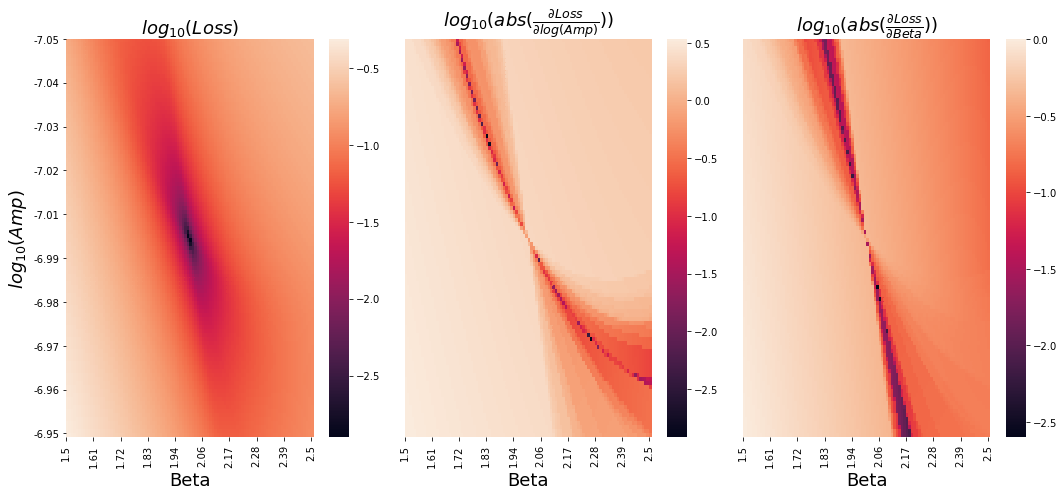

In [155]:
fig,ax=plt.subplots(1,3,figsize=(15,7))

num_ticks = 10
# the index of the position of yticks
ticks = np.linspace(0, 100 - 1, num_ticks, dtype=np.int)
# the content of labels of these yticks
xticklabels = np.round([x_labels[idx] for idx in ticks],2)
yticklabels = np.round([y_labels[idx] for idx in ticks],2)


im=sns.heatmap(ax=ax[0],data=np.log10(GRF_losses_grid),xticklabels=xticklabels,yticklabels=yticklabels)
im.set_yticks(ticks)
im.set_xticks(ticks)

im=sns.heatmap(ax=ax[1],data=np.log10(np.abs(GRF_Amps_grad_grid)),xticklabels=xticklabels,yticklabels=yticklabels)
im.set_yticks(ticks)
im.set_xticks(ticks)

im=sns.heatmap(ax=ax[2],data=np.log10(np.abs(GRF_Betas_grad_grid)),xticklabels=xticklabels,yticklabels=yticklabels)
im.set_yticks(ticks)
im.set_xticks(ticks)

ax[1].set_yticks([])
ax[2].set_yticks([])

fig_names=[r'$log_{10}(Loss)$',r'$log_{10}(abs(\frac{\partial Loss}{\partial log(Amp)}))$',r'$log_{10}(abs(\frac{\partial Loss}{\partial Beta}))$']
for i in range(3):
  ax[i].set_title(fig_names[i],fontsize=FS)
  ax[i].set_xlabel('Beta',fontsize=FS)

ax[0].set_ylabel(r'$log_{10}(Amp)$',fontsize=FS)
fig.tight_layout()

'''fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Beta',fontsize=FS)'''

plt.show()

In [172]:
from scipy.optimize import minimize as scipy_minimize
init_guess=np.array([-1.,GRF_beta])
bounds=((-7.8, -0.), (1.5, 3.0))

Nfeval = 1
history=np.array([[GRF_Amp,GRF_beta]])
def callbackF(Xi,optimizer):
    global Nfeval
    global history
    loss=loss_func(Xi)
    grad=loss_grad(Xi)
    #print('{0:4d}   A{1:3.6f}   {2: 3.6f}   {3: 3.6f}   {4: 3.6f} {5: 3.6f}'.format(Nfeval, np.log10(Xi[0]), Xi[1], loss,grad[0],grad[1]))
    Nfeval += 1
    history=np.append(history,[Xi],axis=0)


res=scipy_minimize(loss_func,init_guess,bounds=bounds,jac=loss_grad,method='trust-constr',options={'disp': True},callback=callbackF)

`xtol` termination condition is satisfied.
Number of iterations: 276, function evaluations: 409, CG iterations: 375, optimality: 2.52e-01, constraint violation: 0.00e+00, execution time: 3.4e+01 s.


In [173]:
history=history[1:]
loss_history=np.array([loss_func(x) for x in history])
grads_history=np.array([loss_grad(x) for x in history])

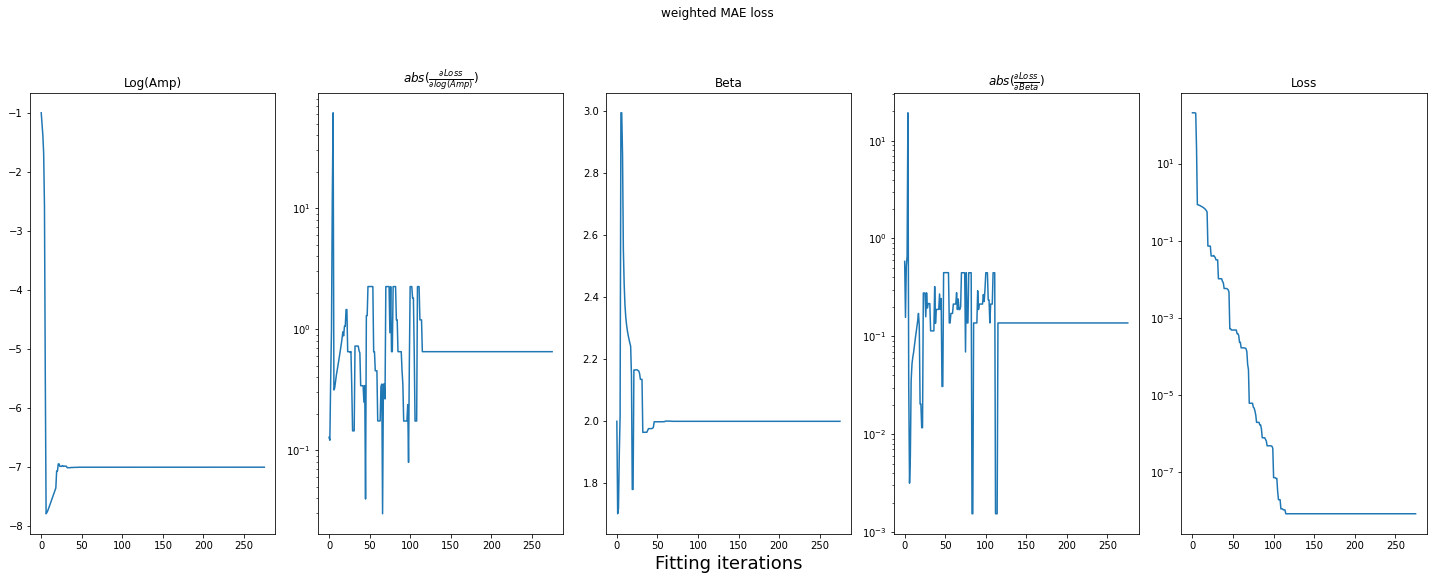

In [175]:
fig,ax=plt.subplots(1,5,figsize=(20,7))

ax[0].plot(history[:,0])
#ax[0].set_yscale('log')
#ax[0].set_xscale('log')
ax[0].set_title('Log(Amp)')

grads_history=np.array(grads_history)
loss_history=np.array(loss_history)

ax[1].plot(np.abs(grads_history[:,0]))
ax[1].set_yscale('log')
#ax[1].set_xscale('log')
ax[1].set_title(r'$abs(\frac{\partial Loss}{\partial log(Amp)})$')


ax[2].plot(history[:,1])
#ax[2].set_yscale('log')
#ax[2].set_xscale('log')
ax[2].set_title('Beta')

ax[3].plot(np.abs(grads_history[:,1]))
ax[3].set_title(r'$abs(\frac{\partial Loss}{\partial Beta})$')
ax[3].set_yscale('log')
#ax[3].set_xscale('log')



ax[4].plot(loss_history)
ax[4].set_yscale('log')
#ax[4].set_xscale('log')
ax[4].set_title('Loss')

fig.tight_layout()
fig.suptitle('weighted MAE loss',y=1.1)



fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Fitting iterations',fontsize=FS)

plt.show()

In [82]:
GRF_Amp

1e-07

In [84]:
GRF_Amps_array=np.linspace(9e-8,1.1e-7,100)
GRF_Betas_array=np.linspace(1.5,2.5,100)

GRF_losses_grid=np.zeros((100,100))
GRF_Amps_grad_grid=np.zeros((100,100))
GRF_Betas_grad_grid=np.zeros((100,100))

for i in tqdm(range(100)):
  for j in range(100):
    GRF_losses_grid[i,j]=loss_func([GRF_Amps_array[i],GRF_Betas_array[j]])
    grad=loss_grad([GRF_Amps_array[i],GRF_Betas_array[j]])
    GRF_Amps_grad_grid[i,j]=grad[0]
    GRF_Betas_grad_grid[i,j]=grad[1]

100%|██████████| 100/100 [08:11<00:00,  4.92s/it]


In [126]:
y_labels=np.round(GRF_Amps_array,9)
x_labels=np.round(GRF_Betas_array,2)

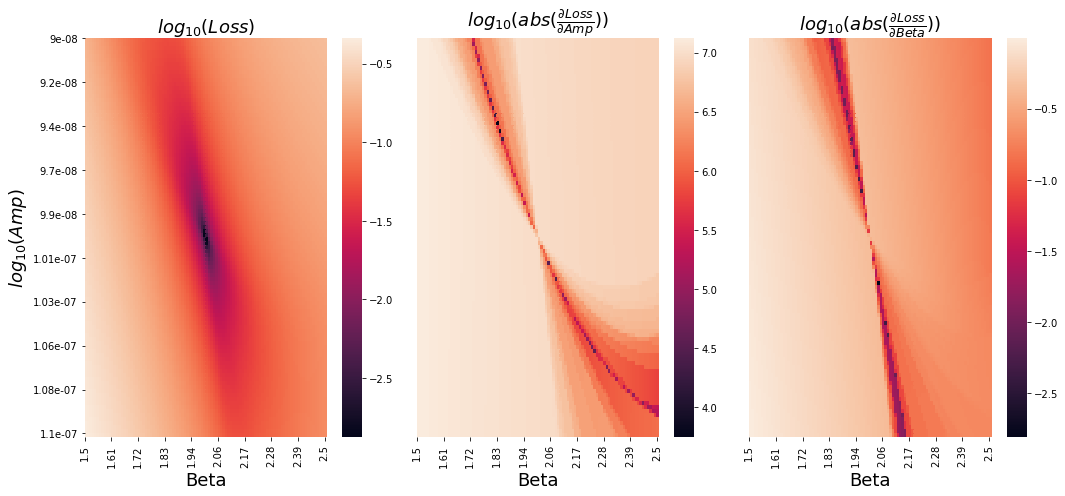

In [136]:
fig,ax=plt.subplots(1,3,figsize=(15,7))

num_ticks = 10
# the index of the position of yticks
ticks = np.linspace(0, 100 - 1, num_ticks, dtype=np.int)
# the content of labels of these yticks
xticklabels = [x_labels[idx] for idx in ticks]
yticklabels = [y_labels[idx] for idx in ticks]


im=sns.heatmap(ax=ax[0],data=np.log10(GRF_losses_grid),xticklabels=xticklabels,yticklabels=yticklabels)
im.set_yticks(ticks)
im.set_xticks(ticks)

im=sns.heatmap(ax=ax[1],data=np.log10(np.abs(GRF_Amps_grad_grid)),xticklabels=xticklabels,yticklabels=yticklabels)
im.set_yticks(ticks)
im.set_xticks(ticks)

im=sns.heatmap(ax=ax[2],data=np.log10(np.abs(GRF_Betas_grad_grid)),xticklabels=xticklabels,yticklabels=yticklabels)
im.set_yticks(ticks)
im.set_xticks(ticks)

ax[1].set_yticks([])
ax[2].set_yticks([])

fig_names=[r'$log_{10}(Loss)$',r'$log_{10}(abs(\frac{\partial Loss}{\partial Amp}))$',r'$log_{10}(abs(\frac{\partial Loss}{\partial Beta}))$']
for i in range(3):
  ax[i].set_title(fig_names[i],fontsize=FS)
  ax[i].set_xlabel('Beta',fontsize=FS)

ax[0].set_ylabel(r'$log_{10}(Amp)$',fontsize=FS)
fig.tight_layout()

'''fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Beta',fontsize=FS)'''

plt.show()

In [86]:
GRF_Amps_grad_grid

array([[13243230.08326687, 13151563.64314117, 13061452.66419695, ...,
        -8010422.70288435, -7994798.47829347, -7979600.2732472 ],
       [13242880.65185287, 13151125.07868233, 13060939.86150128, ...,
        -8009676.81561113, -7994027.68348662, -7978814.6605467 ],
       [13242548.93221026, 13150701.62690629, 13060439.07801976, ...,
        -8008946.9798647 , -7993270.53436372, -7978040.20112255],
       ...,
       [13254064.74887705, 13161510.09179892, 13068506.46731363, ...,
         1215990.00199637,  1232403.28876193,  1248724.69946335],
       [13253221.46853764, 13161014.46067692, 13068271.72203373, ...,
         1216367.55634888,  1232794.29614514,  1249130.2814786 ],
       [13252300.01155816, 13160457.20856407, 13067989.30635781, ...,
         1216741.03948226,  1233180.87230082,  1249531.0817721 ]])

In [75]:
def constrained_grad(x):
  grad=loss_grad(x)
  return grad*1e-10
  

In [76]:
from scipy.optimize import minimize as scipy_minimize
init_guess=np.array([GRF_Amp,GRF_beta])
Amp_bounds=(0.,1.)
Beta_bounds=(0.,10.)
bounds=((9e-8, 1.), (1.1e-7, 3.0))

Nfeval = 1
history=np.array([[GRF_Amp,GRF_beta]])
def callbackF(Xi,optimizer):
    global Nfeval
    global history
    loss=loss_func(Xi)
    grad=loss_grad(Xi)
    #print('{0:4d}   A{1:3.6f}   {2: 3.6f}   {3: 3.6f}   {4: 3.6f} {5: 3.6f}'.format(Nfeval, np.log10(Xi[0]), Xi[1], loss,grad[0],grad[1]))
    Nfeval += 1
    history=np.append(history,[Xi],axis=0)

res=scipy_minimize(loss_func,init_guess,bounds=bounds,jac=constrained_grad,method='trust-constr',options={'disp': True},callback=callbackF)

`xtol` termination condition is satisfied.
Number of iterations: 121, function evaluations: 121, CG iterations: 109, optimality: 6.01e-05, constraint violation: 0.00e+00, execution time: 1.2e+01 s.


In [78]:
loss_history=[loss_func(x) for x in history]
grads_history=[loss_grad(x) for x in history]

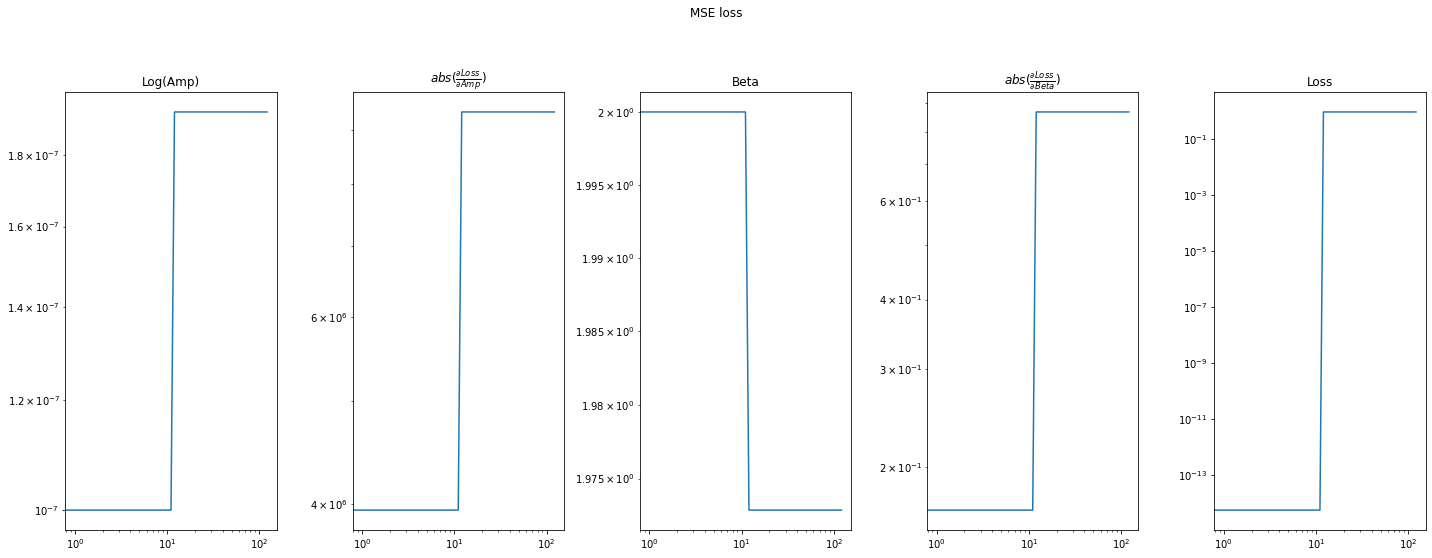

In [79]:
fig,ax=plt.subplots(1,5,figsize=(20,7))

ax[0].plot(history[:,0])
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_title('Log(Amp)')

grads_history=np.array(grads_history)
loss_history=np.array(loss_history)

ax[1].plot(np.abs(grads_history[:,0]))
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_title(r'$abs(\frac{\partial Loss}{\partial Amp})$')


ax[2].plot(history[:,1])
ax[2].set_yscale('log')
ax[2].set_xscale('log')
ax[2].set_title('Beta')

ax[3].plot(np.abs(grads_history[:,1]))
ax[3].set_title(r'$abs(\frac{\partial Loss}{\partial Beta})$')
ax[3].set_yscale('log')
ax[3].set_xscale('log')



ax[4].plot(loss_history)
ax[4].set_yscale('log')
ax[4].set_xscale('log')
ax[4].set_title('Loss')

fig.tight_layout()
fig.suptitle('MSE loss',y=1.1)
plt.show()

In [ ]:
Spectra_Loss_pure=purify_function(Spectra_Loss_MAE,resid_true_spectrum)

GRF_Loss_true_args=(kwargs_true,False,GRF_seed,npix,pix_scl,parameters,
                          get_jaxified_GRF,simulate_perturbed_image_pure,model_loss_function_pure,simulate_smooth_image_pure,\
                          compute_radial_spectrum_pure,Spectra_Loss_pure)
GRF_test_func_pure=purify_function(GRF_test_func,*GRF_Loss_true_args)

GRF_Loss_pure=purify_function(GRF_Loss,*GRF_Loss_true_args)

loss_func=GRF_Loss_pure
loss_grad=jax.grad(GRF_Loss_pure)

In [ ]:
from scipy.optimize import minimize as scipy_minimize
init_guess=np.array([GRF_Amp,GRF_beta])
Amp_bounds=(0.,1.)
Beta_bounds=(0.,10.)
bounds=((0., 1.), (0., 10.0))

Nfeval = 1
history=np.array([[GRF_Amp,GRF_beta]])
def callbackF(Xi,optimizer):
    global Nfeval
    global history
    loss=loss_func(Xi)
    grad=loss_grad(Xi)
    #print('{0:4d}   A{1:3.6f}   {2: 3.6f}   {3: 3.6f}   {4: 3.6f} {5: 3.6f}'.format(Nfeval, np.log10(Xi[0]), Xi[1], loss,grad[0],grad[1]))
    Nfeval += 1
    history=np.append(history,[Xi],axis=0)

res=scipy_minimize(loss_func,init_guess,bounds=bounds,jac=loss_grad,method='trust-constr',options={'disp': True},callback=callbackF)

Invalid value encountered in the output of a jit function. Calling the de-optimized version.
Invalid value encountered in the output of a jit function. Calling the de-optimized version.
Invalid value encountered in the output of a jit function. Calling the de-optimized version.


FloatingPointError: ignored

In [ ]:
history

array([[1.e-07, 2.e+00],
       [1.e-07, 2.e+00]])

In [ ]:
loss_history=[loss_func(x) for x in history]
grads_history=[loss_grad(x) for x in history]

In [ ]:
np.array(grads_history).shape

(1002, 2)

In [ ]:
history.shape

(1002, 2)

In [ ]:
loss_grad([1.09647711e-01, 4.20202634e+02])

[DeviceArray(0., dtype=float64), DeviceArray(-0., dtype=float64)]

In [ ]:
loss_func([1.09647711e-01, 4.20202634e+02])

DeviceArray(23292.61886731, dtype=float64)

In [ ]:
res

      fun: 23292.618867311747
 hess_inv: array([[ 5.46911785e-11, -6.17184352e-06],
       [-6.17184352e-06,  1.00000000e+00]])
      jac: DeviceArray([ 0., -0.], dtype=float64)
  message: 'Optimization terminated successfully.'
     nfev: 5
      nit: 2
     njev: 5
   status: 0
  success: True
        x: array([1.09647711e-01, 4.20202634e+02])

In [ ]:
GRF_Amp

1e-07

In [ ]:
jax.grad(GRF_Loss_pure)([1.,GRF_beta])

[DeviceArray(0.01738866, dtype=float64),
 DeviceArray(-0.77768131, dtype=float64)]

In [ ]:
init_guess=jnp.array([1.,1.])
res=jax_minimize(GRF_Loss_pure,init_guess,method='BFGS')

In [ ]:
res

OptimizeResults(x=DeviceArray([-1.64585951e+07, -1.92057367e+03], dtype=float64), success=DeviceArray(False, dtype=bool), status=DeviceArray(3, dtype=int64), fun=DeviceArray(23010.58837707, dtype=float64), jac=DeviceArray([-5.72257988e+00,  5.23344024e+04], dtype=float64), hess_inv=DeviceArray([[4.24833156e+07, 4.95988777e+03],
             [4.95988777e+03, 5.79062307e-01]], dtype=float64), nfev=DeviceArray(68, dtype=int64), njev=DeviceArray(68, dtype=int64), nit=DeviceArray(4, dtype=int64))

In [ ]:
GRF_Loss()

In [ ]:
jax.grad(GRF_test_func_pure)([GRF_Amp,GRF_beta])

[DeviceArray(665.8967372, dtype=float64),
 DeviceArray(-2.60099595e-05, dtype=float64)]

In [ ]:
loss_grad=jax.grad(GRF_test_func)(model_image,simulated_image)

In [ ]:
model_image,simulated_image=GRF_test_func([GRF_Amp,GRF_beta],*GRF_Loss_args)

In [ ]:
@jax.jit
def test_func(test_value,simulated_image):
  resid=simulated_image-model_image
  resid_spectrum=compute_radial_spectrum_pure(resid)
  return Spectra_Loss_pure(resid_spectrum)


In [ ]:
jax.grad(test_func)(model_image,simulated_image)

DeviceArray([[0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             ...,
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.]], dtype=float64)

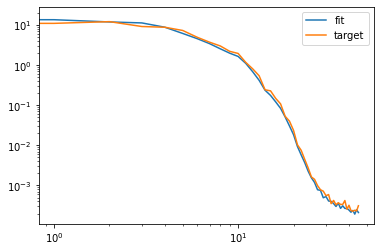

In [ ]:
plt.loglog(Fit_spectrum,label='fit')
plt.loglog(resid0_spectrum,label='target')

plt.legend()
plt.show()


In [ ]:
@jax.partial(jax.jit,static_argnums=(1,2,3,4,5,6,7,8,9,10,11,12))
def GRF_Loss(GRF_params,smooth_kwargs,fit_perturbed,GRF_seed,npix,pix_scl,parameters,
             get_jaxified_GRF,simulate_perturbed_image_pure,model_loss_function_pure,simulate_smooth_image_pure,\
             compute_radial_spectrum_pure,Spectra_Loss_pure):

  GRF=get_jaxified_GRF(GRF_params,GRF_seed,npix,pix_scl)

  simulated_image=simulate_perturbed_image_pure(GRF)

  if fit_perturbed:
    init_guess=parameters.kwargs2args(smooth_kwargs)
    res=jax_minimize(model_loss_function_pure,init_guess,args=(simulated_image,),method='BFGS')
    kwargs_final=parameters.args2kwargs(res.x)
  else:
    kwargs_final=smooth_kwargs

  model_image=simulate_smooth_image_pure(kwargs_final)
  
  resid=simulated_image-model_image
  resid_spectrum=compute_radial_spectrum_pure(resid)

  return Spectra_Loss_pure(resid_spectrum)

In [ ]:
jax.grad(jax.jit(model_loss_function_pure))(parameters.kwargs2args(kwargs_true),data)

DeviceArray([ 2.15709421, -2.22034178,  1.14750613,  0.20213264,
             -0.68418736,  3.65897726, -1.97449107,  0.41682199,
              1.81079613,  3.36752357, -0.81712177,  1.63825417,
              1.95566351, -1.33592452], dtype=float64)

In [ ]:
jax.grad(jax.jit(model_loss_function_pure))(args0,data)

DeviceArray([ 0.7111865 , -1.07739876, -0.54554087, -1.32432575,
             -0.34257348,  2.52435763,  0.61983202, -0.07196772,
             -0.46105275, -0.28075608,  0.49341731, -0.94949696,
              2.19202592,  0.00557335], dtype=float64)

In [ ]:
jax.grad(jax.jit(model_loss_function_pure))(np.ones((14,)),data)

DeviceArray([ 1.17113557e-27,  3.71521224e-28, -3.71521224e-28,
             -1.93425179e-28,  3.77262439e-28, -3.60524726e-26,
              4.18714434e-26, -7.99003518e-31, -5.12277615e-29,
             -1.27165359e-28, -9.11782044e-28,  9.11782044e-28,
              7.81606973e-27, -1.88696305e-26], dtype=float64)

In [ ]:
loss=GRF_Loss([GRF_Amp,GRF_beta],kwargs0,True,GRF_seed,npix,pix_scl,parameters,
              get_jaxified_GRF,simulate_perturbed_image_pure,model_loss_function_pure,simulate_smooth_image_pure,compute_radial_spectrum_pure,Spectra_Loss_pure)

In [ ]:
loss

DeviceArray(1.06451627, dtype=float64)

In [ ]:
grad_loss=jax.grad(GRF_Loss)([GRF_Amp,GRF_beta],kwargs0,True,GRF_seed,npix,pix_scl,parameters,
              get_jaxified_GRF,simulate_perturbed_image_pure,model_loss_function_pure,simulate_smooth_image_pure,compute_radial_spectrum_pure,Spectra_Loss_pure)

KeyboardInterrupt: ignored

Fails to propagate gradients through the fit

In [ ]:
grad_loss=jax.grad(GRF_Loss)([GRF_Amp,GRF_beta],kwargs0,False,GRF_seed,npix,pix_scl,parameters,
              get_jaxified_GRF,simulate_perturbed_image_pure,model_loss_function_pure,simulate_smooth_image_pure,compute_radial_spectrum_pure,Spectra_Loss_pure)

In [ ]:
grad_loss

[DeviceArray(53140024.12990661, dtype=float64),
 DeviceArray(-1.26190547, dtype=float64)]

In [ ]:
GRF_Loss_args=(kwargs0,False,GRF_seed,npix,pix_scl,parameters,
              get_jaxified_GRF,simulate_perturbed_image_pure,model_loss_function_pure,simulate_smooth_image_pure,compute_radial_spectrum_pure,Spectra_Loss_pure)

In [ ]:
GRF_guess=np.array([GRF_Amp,3.])
grad_loss=jax.grad(GRF_Loss)(GRF_guess,*GRF_Loss_args)

In [ ]:
grad_loss

DeviceArray([6.38380724e+07, 3.03083870e+00], dtype=float64)

In [ ]:
GRF_guess=np.array([0.,3.])
res=jax_minimize(GRF_Loss,GRF_guess,args=(GRF_Loss_args),method='BFGS')

FloatingPointError: ignored

In [ ]:
def GRF_Loss(GRF_params,seed,npix,pix_scl,perturbed_simulation_func,model_loss_function,model_simulation_func,compute_radial_spectrum_func):

  GRF=get_jaxified_GRF(GRF_params,seed,npix,pix_scl)

  simulated_image=perturbed_simulation_func(GRF)

  res=jax_minimize(model_loss_function,args0,args=(simulated_image,model_simulation_func),method='BFGS')
  model_image=model_simulation_func(res.x)
  
  resid=simulated_image-model_image
  resid_spectrum=compute_radial_spectrum_func(resid)

  return Spectra_MSE(resid_spectrum)

In [ ]:
def get_fitting_necessities(kwargs0):
    perturbed_lens_image = LensImage(pixel_grid, psf, noise_class=noise,
                         lens_model_class=LensModel(lens_mass_model_list),
                         source_model_class=source_light_model,
                         lens_light_model_class=lens_light_model,
                         kwargs_numerics=kwargs_numerics)

    smooth_lens_image = LensImage(pixel_grid, psf, noise_class=noise,
                         lens_model_class=LensModel(lens_mass_model_list[:-1]),
                         source_model_class=source_light_model,
                         lens_light_model_class=lens_light_model,
                         kwargs_numerics=kwargs_numerics)
    
    parameters=get_parameters(kwargs0)
    args0=parameters.kwargs2args(kwargs0)

    def model_simulation_func(args):
      kwargs=parameters.args2kwargs(args)
      return smooth_lens_image.model(**kwargs)

    def perturbed_simulation_func(GRF):
      kwargs_lens_mass_sim = kwargs0['kwargs_lens']+[{'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': GRF}]

      return perturbed_lens_image.model(kwargs_lens=kwargs_lens_mass_sim,
                                        kwargs_source=kwargs0['kwargs_source'],
                                        kwargs_lens_light=kwargs0['kwargs_lens_light'])


    return jax.jit(model_simulation_func),jax.jit(perturbed_simulation_func),args0

def model_loss_function(args,data,model_func):
    model=model_func(args)
    return jnp.sum((data-model)**2)

model_simulation_func,perturbed_simulation_func,args0=get_fitting_necessities(kwargs0)
jax.grad(loss_function)(args0,data,model_simulation_func)

DeviceArray([ 0.7111865 , -1.07739876, -0.54554087, -1.32432575,
             -0.34257348,  2.52435763,  0.61983202, -0.07196772,
             -0.46105275, -0.28075608,  0.49341731, -0.94949696,
              2.19202592,  0.00557335], dtype=float64)

In [ ]:
res=jax_minimize(model_loss_function,args0,args=(image,model_simulation_func),method='BFGS')

<BarContainer object of 14 artists>

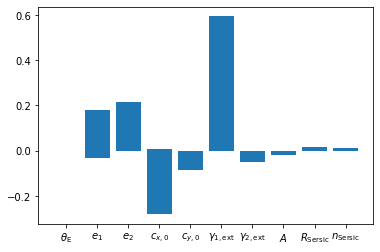

In [ ]:
plt.bar(parameters.symbols ,(args0-res.x)/args0)

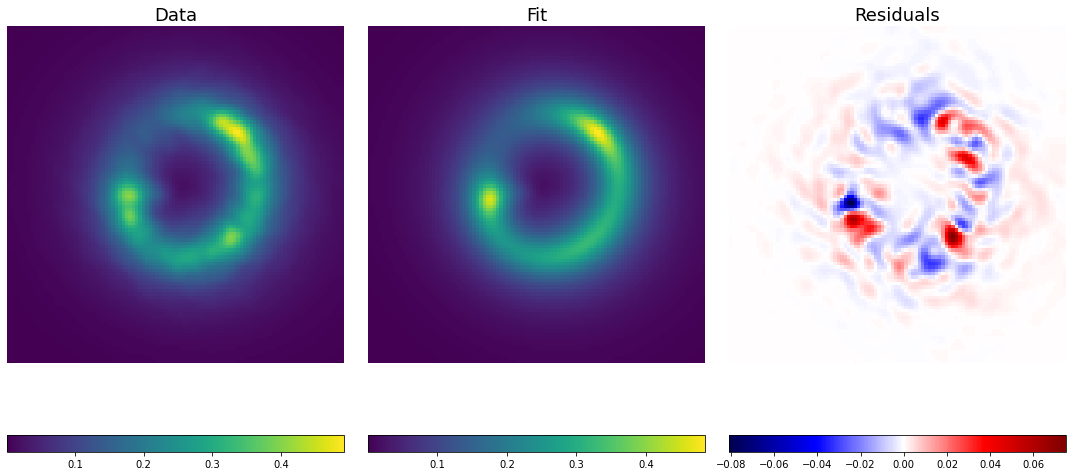

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 7))

im0=ax[0].imshow(image, origin='lower')
ax[0].set_title("Data", fontsize=FS)

model_image=model_simulation_func(res.x)

im1=ax[1].imshow(model_image, origin='lower')
ax[1].set_title("Fit", fontsize=FS)

im2=ax[2].imshow(image-model_image, origin='lower',cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
ax[2].set_title("Residuals", fontsize=FS)

for i,img in enumerate([im0,im1, im2]):
    ax[i].axis('off')
    fig.colorbar(img, ax=ax[i],orientation='horizontal')

fig.tight_layout()

### jaxified GRF fitting

In [ ]:
model_simulation_func,perturbed_simulation_func,args0=get_fitting_necessities(kwargs0)

def get_Spectra_MSE(True_array):
  def Spectra_MSE(Fit_array):
    return jnp.mean(jnp.power(Fit_array-True_array,2))

  return jax.jit(Spectra_MSE)

Spectra_MSE=get_Spectra_MSE(resid0_spectrum)

In [ ]:
def get_compute_radial_spectrum_func(npix,pix_scl,image_masking_func,mask_spectral_cut_index,RadProf_getter):
  def func(image):
    return compute_radial_spectrum(image,npix,pix_scl,image_masking_func,mask_spectral_cut_index,RadProf_getter)
  return func

compute_radial_spectrum_func=jax.jit(get_compute_radial_spectrum_func(npix,pix_scl,jax.tree_util.Partial(masking_function),mask_spectral_cut_index,RadProf_getter))

In [ ]:
@jax.partial(jax.jit,static_argnums=(1,2,3,4,5,6,7))
def GRF_Loss(GRF_params,seed,npix,pix_scl,perturbed_simulation_func,model_loss_function,model_simulation_func,compute_radial_spectrum_func):

  GRF=get_jaxified_GRF(GRF_params,seed,npix,pix_scl)

  simulated_image=perturbed_simulation_func(GRF)

  res=jax_minimize(model_loss_function,args0,args=(simulated_image,model_simulation_func),method='BFGS')
  model_image=model_simulation_func(res.x)
  
  resid=simulated_image-model_image
  resid_spectrum=compute_radial_spectrum_func(resid)

  return Spectra_MSE(resid_spectrum)

In [ ]:
GRF_related_functions=[perturbed_simulation_func,jax.tree_util.Partial(model_loss_function),model_simulation_func,compute_radial_spectrum_func]

In [ ]:
Loss=GRF_Loss([GRF_Amp,GRF_beta],GRF_seed,npix,pix_scl,*GRF_related_functions)

In [ ]:
Loss

DeviceArray(0.83459532, dtype=float64)

In [ ]:
jax.grad(GRF_Loss)([GRF_Amp,GRF_beta],GRF_seed,npix,pix_scl,*GRF_related_functions)

ValueError: ignored

In [ ]:
@jax.partial(jax.jit,static_argnums=(1,2,3,4,5,6,7))
def GRF_Loss(GRF_params,seed,npix,pix_scl,perturbed_simulation_func,model_loss_function,model_simulation_func,compute_radial_spectrum_func):

  GRF=get_jaxified_GRF(GRF_params,seed,npix,pix_scl)

  simulated_image=perturbed_simulation_func(GRF)

  return jnp.mean(simulated_image)

In [ ]:
jax.grad(GRF_Loss)([GRF_Amp,GRF_beta],GRF_seed,npix,pix_scl,*GRF_related_functions)

[DeviceArray(-2319.876232, dtype=float64),
 DeviceArray(-7.21166873e-05, dtype=float64)]

In [ ]:
@jax.partial(jax.jit,static_argnums=(1,2,3,4,5,6,7))
def GRF_Loss(GRF_params,seed,npix,pix_scl,perturbed_simulation_func,model_loss_function,model_simulation_func,compute_radial_spectrum_func):

  GRF=get_jaxified_GRF(GRF_params,seed,npix,pix_scl)

  simulated_image=perturbed_simulation_func(GRF)

  res=jax_minimize(model_loss_function,args0,args=(simulated_image,model_simulation_func),method='BFGS')
  return jnp.mean(res.x)

In [ ]:
jax.grad(GRF_Loss)([GRF_Amp,GRF_beta],GRF_seed,npix,pix_scl,*GRF_related_functions)

ValueError: ignored

In [ ]:
def get_parameters(kwargs):

  kwargs_model = {
    'lens_model_list': lens_mass_model_list[:-1],
    'source_model_list': source_light_model_list,
    'lens_light_model_list': [],
  }

  kwargs_init = {
    'kwargs_lens': kwargs['kwargs_lens'],
    'kwargs_source': kwargs['kwargs_source'],
  }


  kwargs_prior = {
    'kwargs_lens': [{'theta_E': ['uniform', 1., 2.], 'e1': ['gaussian', 0, 0.2], 'e2': ['gaussian', 0, 0.2], \
                     'center_x': ['gaussian', 0, 0.102], 'center_y': ['gaussian', 0, 0.102]}, {'gamma1': ['uniform', -0.5, 0.5], 'gamma2': ['uniform', -0.5, 0.5]}],
                  
    'kwargs_source': [{'amp': ['uniform',5.0,20.0], 'R_sersic': ['uniform',1e-3,5.], 'n_sersic': ['uniform',1e-3,4.0],\
                       'center_x': ['uniform', -1.0, 1.0], 'center_y': ['uniform', -1.0, 1.0],'e1': ['gaussian', 0, 0.2], 'e2': ['gaussian', 0, 0.2]}],
  }
  
  kwargs_fixed = {
    'kwargs_lens': [{}, {'ra_0': 0., 'dec_0': 0.}],  # fix origin of the external shear profile
    'kwargs_source': [{}],  # fix all source parameters
    }

  parameters = Parameters(kwargs_model, kwargs_init, kwargs_prior, kwargs_fixed)

  return parameters

In [ ]:
lens_image.Noise.C_D

array([[2.45508717e-05, 2.45823579e-05, 2.46190466e-05, ...,
        2.52065444e-05, 2.51683568e-05, 2.51451814e-05],
       [2.45786249e-05, 2.46029886e-05, 2.46326625e-05, ...,
        2.52802247e-05, 2.52397212e-05, 2.52146278e-05],
       [2.46082451e-05, 2.46267385e-05, 2.46503090e-05, ...,
        2.53816367e-05, 2.53347873e-05, 2.53034884e-05],
       ...,
       [2.50036124e-05, 2.50571547e-05, 2.51264129e-05, ...,
        2.53034686e-05, 2.52513770e-05, 2.52114207e-05],
       [2.49372206e-05, 2.49986485e-05, 2.50741008e-05, ...,
        2.51834878e-05, 2.51302513e-05, 2.50866323e-05],
       [2.48768108e-05, 2.49497862e-05, 2.50340374e-05, ...,
        2.50851273e-05, 2.50279553e-05, 2.49789038e-05]])

In [ ]:
noise

In [ ]:
def get_model_simulation_func(kwargs0):
    smooth_lens_image = LensImage(pixel_grid, psf, noise_class=noise,
                         lens_model_class=LensModel(lens_mass_model_list[:-1]),
                         source_model_class=source_light_model,
                         lens_light_model_class=lens_light_model,
                         kwargs_numerics=kwargs_numerics)
    parameters=get_parameters(kwargs0)
    args0=parameters.kwargs2args(kwargs0)

    def model_simulation_func(args):
      kwargs=parameters.args2kwargs(args)
      return smooth_lens_image.model(**kwargs)

    return model_simulation_func,args0

def model_loss_function(args,data,model_func):
    model=model_func(args)
    return jnp.sum((data-model)**2)

In [ ]:
model_func,args0=get_model_func(kwargs0)

In [ ]:
jax.grad(loss_function)(args0,data,jax.tree_util.Partial(model_func))

DeviceArray([ 0.7111865 , -1.07739876, -0.54554087, -1.32432575,
             -0.34257348,  2.52435763,  0.61983202, -0.07196772,
             -0.46105275, -0.28075608,  0.49341731, -0.94949696,
              2.19202592,  0.00557335], dtype=float64)

In [ ]:
args0

DeviceArray([ 1.59901361e+00,  1.54921279e-01, -2.64147730e-02,
              8.06590962e-03,  1.27748086e-02, -4.92914288e-03,
              3.60050795e-02,  9.97775490e+00,  1.20117705e+00,
              1.42337431e+00,  5.76799535e-02, -1.04179120e-01,
              3.91039100e-01,  1.54149290e-01], dtype=float64)

In [ ]:
simulate_image_from_GRF,loss_function,parameters=getter_fitting_functions(kwargs0)

In [ ]:
def fitting_function

In [ ]:
@jax.partial(jax.jit,static_argnums=(1,2,3))
def test_func(x0,GRF_seed,npix,pix_scl,simulate_image_func,smooth_lens_image):
  GRF=get_jaxified_GRF(x0,GRF_seed,npix,pix_scl)

  image_sim=simulate_image_from_GRF(GRF)

  x0=parameters.kwargs2args(kwargs0)
  res=jax_minimize(loss_function,x0,args=(get_hashable_MSE(GRF_realisation),GRF_seed,npix,pix_scl),method='BFGS')

  return res

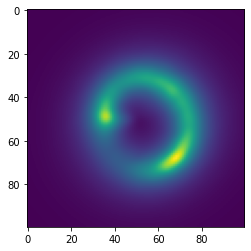

In [ ]:
plt.imshow(simulate_image_from_GRF(GRF))

As expected grads only in masked area.

Осталось проверить как работает фитирование через jaxtronomy, а в остальном все должно быть норм.

Если не работает, то я сам могу написать его через jax_minimize

In [ ]:
x0

array([1.e-08, 3.e+00])

In [ ]:



simulate_image_func=jax.tree_util.Partial(get_simulate_image_func(kwargs0,lens_image))
smooth_lens_image,kwargs_true=get_model(kwargs0)
parameters=get_parameters(kwargs0)

@jax.partial(jax.jit,static_argnums=(1,2,3))
def test_func(x0,GRF_seed,npix,pix_scl,simulate_image_func,smooth_lens_image):
  GRF=get_jaxified_GRF(x0,GRF_seed,npix,pix_scl)

  image_sim=simulate_image_func(GRF)

  smooth_lens_image,kwargs_true=get_model(kwargs0)
  parameters=get_parameters(kwargs0)
  args1,fisher_matrix1=fit_data(image_sim,smooth_lens_image,parameters)

  return args1

In [ ]:
test_func(x0,GRF_seed,npix,pix_scl,simulate_image_func)

TracerArrayConversionError: ignored

In [ ]:
def get_lens_img_parameters_func(lens_image,parameters):
  def get_lens_img_parameters():
    return lens_image,parameters

  return get_lens_img_parameters


smooth_lens_image,kwargs_true=get_model(kwargs0)
parameters=get_parameters(kwargs0)
get_lens_img_parameters=jax.tree_util.Partial(get_lens_img_parameters_func(smooth_lens_image,parameters))


@jax.partial(jax.jit, static_argnums=(1))
def fit_data(data,get_lens_img_parameters):

  lens_image,parameters=get_lens_img_parameters()

  loss = Loss(data, lens_image, parameters)
  grad_loss = jax.jit(jax.grad(loss))

  optimizer = Optimizer(loss, parameters)
  #BFGS for gradient only, Newton-CG for graident+ hessian vector product
  #BFGS is faster since it doesn't compute hessian vp
  best_fit, logL, extra_fields, runtime \
    = optimizer.minimize(method='BFGS', restart_from_init=True,
                         use_exact_hessian_if_allowed=False)
    
  kwargs_final = parameters.ML_values(as_kwargs=True)
  if extra_fields['hess_inv'] is not None:
    fisher_matrix = extra_fields['hess_inv']
  else:
    hess_ml = optimizer.hessian(best_fit)
    fisher_matrix = jax.numpy.linalg.inv(hess_ml)

  return parameters.kwargs2args(kwargs_final),fisher_matrix

In [ ]:
@jax.jit
def test_func(data):
  loss = Loss(data, smooth_lens_image, parameters)
  grad_loss = jax.jit(jax.grad(loss))

  res=jax_minimize(loss,)

In [ ]:
test_func(data)

TracerArrayConversionError: ignored

In [ ]:
fit_data(image,get_lens_img_parameters)

TracerArrayConversionError: ignored

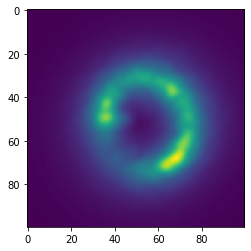

In [ ]:
plt.imshow(image)

In [ ]:
args1

DeviceArray([ 1.59847475e+00,  1.53554617e-01, -2.78951012e-02,
              7.21399783e-03,  2.03408859e-02, -4.29538267e-03,
              3.56383093e-02,  9.82957392e+00,  1.20758874e+00,
              1.42466474e+00,  5.49933037e-02, -1.03742768e-01,
              3.86721876e-01,  1.58569157e-01], dtype=float64)

In [ ]:
def traced_GRF_Loss(x,seed,kwargs0,lens_image,resid0_spectrum):
  GRF=get_jaxified_GRF(x,seed,npix,pix_scl)

  kwargs_lens_mass_sim = kwargs0['kwargs_lens']+[{'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': fit_GRF}]

  image_sim=lens_image.model(kwargs_lens=kwargs_lens_mass_sim,
                          kwargs_source=kwargs0['kwargs_source'],
                          kwargs_lens_light=kwargs0['kwargs_lens_light'])

  smooth_lens_image,kwargs_true=get_model(kwargs0)
  parameters=get_parameters(kwargs0)
  args1,fisher_matrix1=fit_data(image_sim,smooth_lens_image,parameters)

  kwargs1=parameters.args2kwargs(args1)
  model1=smooth_lens_image.model(kwargs_lens=kwargs1['kwargs_lens'],
                          kwargs_source=kwargs1['kwargs_source'],
                          kwargs_lens_light=kwargs1['kwargs_lens_light'])
  
  resid1=(image_sim-model1)
  resid1_spectrum=compute_radial_spetrum(resid1)

  loss=np.mean(np.power((resid0_spectrum-resid1_spectrum)/resid1_spectrum,2))
  print('loss',loss)
  print('fit_Amplitude',fit_Amplitude)
  print('fit_Beta',fit_Beta)
  return loss

In [ ]:
mask_spectral_cut_index

4

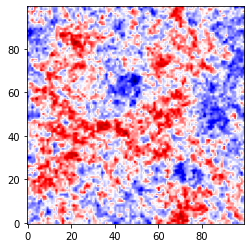

In [ ]:
plt.imshow(GRF_realisation,origin='lower',cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))

In [ ]:
def get_hashable_MSE(True_array):
  def MSE(Fit_array):
    return jnp.mean(jnp.power(Fit_array-True_array,2))

  return jax.tree_util.Partial(MSE)

In [ ]:
MSE=get_hashable_MSE(GRF_realisation)

In [ ]:
@jax.partial(jax.jit,static_argnums=(1,2,3,4))
def Loss_GRF_potential(params,loss,seed,npix,pix_scl):
  A,beta=params
  GRF=get_jaxified_GRF([A,beta],seed,npix,pix_scl)
  return loss(GRF)

In [ ]:
def func()

In [ ]:
GRF=jnp.array(GRF_realisation)
GRF

DeviceArray([[-0.01243255, -0.00829889,  0.00402387, ..., -0.00904885,
              -0.00604214, -0.00302176],
             [-0.00226499, -0.01453809, -0.0219767 , ...,  0.01113688,
               0.00434794,  0.00886271],
             [ 0.00602436, -0.01029537, -0.01696046, ...,  0.01601606,
               0.01204917,  0.00664493],
             ...,
             [ 0.01468725,  0.00566183,  0.01739841, ..., -0.0066037 ,
               0.00138568,  0.01062642],
             [-0.00426157, -0.00196087, -0.01263381, ..., -0.00767667,
              -0.00317466, -0.00206083],
             [-0.01814698,  0.00783441, -0.00736378, ..., -0.01183791,
              -0.02245846, -0.02427405]], dtype=float64)

In [ ]:
  kwargs_lens_mass_sim = kwargs0['kwargs_lens']+[{'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': GRF}]

  image_sim=lens_image.model(kwargs_lens=kwargs_lens_mass_sim,
                          kwargs_source=kwargs0['kwargs_source'],
                          kwargs_lens_light=kwargs0['kwargs_lens_light'])
  
  smooth_lens_image,kwargs_true=get_model(kwargs0)
  parameters=get_parameters(kwargs0)

In [ ]:
args1,fisher_matrix1=fit_data(image_sim,smooth_lens_image,parameters)

In [ ]:
  kwargs1=parameters.args2kwargs(args1)
  model1=smooth_lens_image.model(kwargs_lens=kwargs1['kwargs_lens'],
                          kwargs_source=kwargs1['kwargs_source'],
                          kwargs_lens_light=kwargs1['kwargs_lens_light'])

In [ ]:
def get_coord(a, b):
    return jnp.array([a, b, a+b])

In [ ]:
f0 = jnp.vectorize(get_coord, signature='(),()->(i)')

In [ ]:
f0(1,2)

DeviceArray([1, 2, 3], dtype=int64)

In [ ]:
jax.vmap(get_coord, (None, 0))(1,2)

ValueError: ignored

In [ ]:
def func(image,mask):
  return image[mask]

In [ ]:
    #Centered arrays
    x=np.arange(npix)-npix/2+0.5
    y=np.arange(npix)-npix/2+0.5
    X,Y=np.meshgrid(x,y)
    #Matrix of radii
    R=np.sqrt(np.power(X,2)+np.power(Y,2))

In [ ]:
R_mask_tensor=np.zeros((npix//2,npix,npix))
for i in range(npix//2):
  R_mask_tensor[i]=jnp.where(R<i+1,1,0)

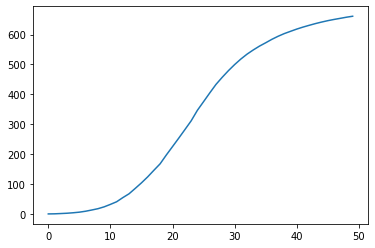

In [ ]:
plt.plot(masked_image_tensor.sum(axis=(1,2)))

In [ ]:
masked_image_tensor=image*R_mask_tensor

In [ ]:
R_mask_tensor

In [ ]:
R_mask_tensor.sum(axis=(1,2))

array([4.000e+00, 1.200e+01, 3.200e+01, 5.200e+01, 8.000e+01, 1.120e+02,
       1.560e+02, 2.080e+02, 2.560e+02, 3.160e+02, 3.840e+02, 4.480e+02,
       5.400e+02, 6.160e+02, 7.160e+02, 8.120e+02, 9.120e+02, 1.020e+03,
       1.124e+03, 1.264e+03, 1.396e+03, 1.528e+03, 1.664e+03, 1.804e+03,
       1.976e+03, 2.128e+03, 2.292e+03, 2.472e+03, 2.644e+03, 2.828e+03,
       3.024e+03, 3.228e+03, 3.436e+03, 3.640e+03, 3.852e+03, 4.060e+03,
       4.304e+03, 4.548e+03, 4.792e+03, 5.024e+03, 5.284e+03, 5.544e+03,
       5.808e+03, 6.092e+03, 6.376e+03, 6.668e+03, 6.948e+03, 7.232e+03,
       7.556e+03, 7.860e+03])

In [ ]:
image_tensor=np.tile(image,npix//2).reshape((50,100,100))

In [ ]:
np.tile(image,(npix,npix,npix//2)).shape

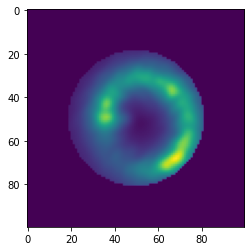

In [ ]:
plt.imshow(masked_image_tensor[30,:,:])

In [ ]:
np.full_like(R_mask_tensor,image)

ValueError: ignored

In [ ]:
image*R_mask_tensor

ValueError: ignored

In [ ]:
np.dot(image,R_mask_tensor).shape

(100, 100, 50)

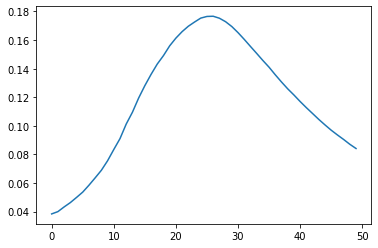

In [ ]:
plt.plot(traced_Radial_profile(image,IncCurve_getter))

DeviceArray([0.03836226, 0.03995548, 0.04323497, 0.04626732, 0.04987886,
             0.05361692, 0.0584339 , 0.0635839 , 0.06888503, 0.07554778,
             0.08342682, 0.09104669, 0.10122788, 0.10949179, 0.11942884,
             0.12810603, 0.13598429, 0.14322652, 0.14914984, 0.1559846 ,
             0.16137822, 0.16590295, 0.16967433, 0.17261942, 0.1753749 ,
             0.17652953, 0.17667687, 0.17530462, 0.17285831, 0.16947396,
             0.16521732, 0.1605099 , 0.15556241, 0.15069511, 0.14573063,
             0.14100974, 0.13570901, 0.13067435, 0.12589644, 0.12158516,
             0.11701594, 0.11272246, 0.10862776, 0.10450532, 0.10065291,
             0.09695115, 0.09362738, 0.0904631 , 0.08708652, 0.08412823],            dtype=float64)

In [ ]:
def get_IncCurve_counter_func(npix):
    #Centered arrays
    x=np.arange(npix)-npix/2+0.5
    y=np.arange(npix)-npix/2+0.5
    X,Y=np.meshgrid(x,y)
    #Matrix of radii
    R=np.sqrt(np.power(X,2)+np.power(Y,2))

    R_mask_tensor=np.zeros((npix//2,npix,npix))
    for i in range(npix//2):
      R_mask_tensor[i]=jnp.where(R<i+1,1,0)
    
    def func(image):
      return (image*R_mask_tensor).sum(axis=(1,2)),R_mask_tensor.sum(axis=(1,2))

    return func

IncCurve_counter_getter=get_IncCurve_counter_func(npix)

In [ ]:
#Get function that will compute (increase_curve,pix_counter) for specific image shape
def get_IncCurve_func(npix):
    #Centered arrays
    x=np.arange(npix)-npix/2+0.5
    y=np.arange(npix)-npix/2+0.5
    X,Y=np.meshgrid(x,y)
    #Matrix of radii
    R=np.sqrt(np.power(X,2)+np.power(Y,2))

    R_mask_tensor=np.zeros((npix//2,npix,npix))
    for i in range(npix//2):
      R_mask_tensor[i]=jnp.where(R<i+1,1,0)
    
    #The function that does computation
    def IncCurve_getter(image):
      return (image*R_mask_tensor).sum(axis=(1,2)),R_mask_tensor.sum(axis=(1,2))

    return jax.tree_util.Partial(IncCurve_getter)

IncCurve_getter=get_IncCurve_counter_func(npix)

#Getting Radial profile in pure fashion
@jax.partial(jax.jit,static_argnums=1)
def traced_Radial_profile(image,IncCurve_getter):
    
    increase_curve,counter=IncCurve_getter(image)

    radial_profile=increase_curve/counter
    return radial_profile

def compute_radial_spetrum(image,pix_scl=pix_scl,mask=mask):
  #Scales larger than the size of the masked region (Einstein ring)
  masked_image=image*mask

  spectrum=np.fft.fft2(masked_image)
  half_im_size=image.shape[0]//2
  Centered_Spectrum=np.roll(np.abs(spectrum)**2,half_im_size,axis=(0,1))
  
  return Radial_profile(Centered_Spectrum)[mask_spectral_cut_index:]

In [ ]:
traced_Radial_profile(image,npix)

TypeError: ignored

In [ ]:
len(jnp.where(R<0+1)[0])

4

In [ ]:
image[jnp.where(R<i)].sum()

DeviceArray(0.4794657, dtype=float64)

In [ ]:
image

In [ ]:
(jnp.where(R<i,1,0)*image).sum()

DeviceArray(0.4794657, dtype=float64)

In [ ]:
len(x[:49])

49

In [ ]:
R

array([[70.00357134, 69.30007215, 68.60393575, ..., 68.60393575,
        69.30007215, 70.00357134],
       [69.30007215, 68.58935778, 67.88593374, ..., 67.88593374,
        68.58935778, 69.30007215],
       [68.60393575, 67.88593374, 67.17514421, ..., 67.17514421,
        67.88593374, 68.60393575],
       ...,
       [68.60393575, 67.88593374, 67.17514421, ..., 67.17514421,
        67.88593374, 68.60393575],
       [69.30007215, 68.58935778, 67.88593374, ..., 67.88593374,
        68.58935778, 69.30007215],
       [70.00357134, 69.30007215, 68.60393575, ..., 68.60393575,
        69.30007215, 70.00357134]])

In [ ]:
Radial_profile(R)

In [ ]:
X[0][49:51]

array([-0.5,  0.5])

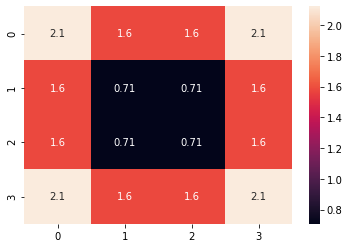

In [ ]:
sns.heatmap(R[48:52,48:52],annot=True)

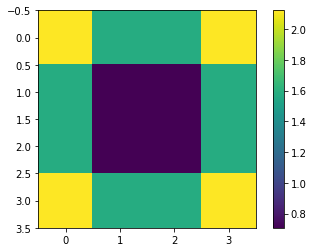

In [ ]:
plt.imshow()
plt.colorbar()

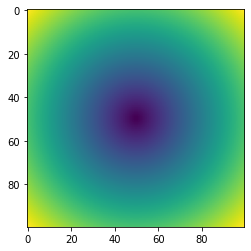

In [ ]:
plt.imshow(R)

In [ ]:
x

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [ ]:
R[50]

array([50., 49., 48., 47., 46., 45., 44., 43., 42., 41., 40., 39., 38.,
       37., 36., 35., 34., 33., 32., 31., 30., 29., 28., 27., 26., 25.,
       24., 23., 22., 21., 20., 19., 18., 17., 16., 15., 14., 13., 12.,
       11., 10.,  9.,  8.,  7.,  6.,  5.,  4.,  3.,  2.,  1.,  0.,  1.,
        2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
       15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
       28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40.,
       41., 42., 43., 44., 45., 46., 47., 48., 49.])

In [ ]:
q=jnp.array([1,2,3])
q

DeviceArray([1, 2, 3], dtype=int64)

In [ ]:
q[0]=q[0]+1

TypeError: ignored

In [ ]:
def traced_GRF_Loss(x,seed,kwargs0,lens_image,resid0_spectrum):
  GRF=get_jaxified_GRF(x,seed,npix,pix_scl)

  kwargs_lens_mass_sim = kwargs0['kwargs_lens']+[{'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': fit_GRF}]

  image_sim=lens_image.model(kwargs_lens=kwargs_lens_mass_sim,
                          kwargs_source=kwargs0['kwargs_source'],
                          kwargs_lens_light=kwargs0['kwargs_lens_light'])

  smooth_lens_image,kwargs_true=get_model(kwargs0)
  parameters=get_parameters(kwargs0)
  args1,fisher_matrix1=fit_data(image_sim,smooth_lens_image,parameters)

  kwargs1=parameters.args2kwargs(args1)
  model1=smooth_lens_image.model(kwargs_lens=kwargs1['kwargs_lens'],
                          kwargs_source=kwargs1['kwargs_source'],
                          kwargs_lens_light=kwargs1['kwargs_lens_light'])
  
  resid1=(image_sim-model1)
  resid1_spectrum=compute_radial_spetrum(resid1)

  loss=np.mean(np.power((resid0_spectrum-resid1_spectrum)/resid1_spectrum,2))
  print('loss',loss)
  print('fit_Amplitude',fit_Amplitude)
  print('fit_Beta',fit_Beta)
  return loss

In [ ]:
Loss_GRF_potential([GRF_Amp,GRF_beta],get_hashable_MSE(GRF_realisation),GRF_seed,npix,pix_scl)

DeviceArray(2.64848834e-35, dtype=float64)

In [ ]:
jax.grad(Loss_GRF_potential)([1e-8,3.0],get_hashable_MSE(GRF_realisation),GRF_seed,npix,pix_scl)

[DeviceArray(-2934.41235589, dtype=float64),
 DeviceArray(-5.87820477e-06, dtype=float64)]

In [ ]:
x0=np.array([1e-8,3.])
res=jax_minimize(Loss_GRF_potential,x0,args=(get_hashable_MSE(GRF_realisation),GRF_seed,npix,pix_scl),method='BFGS')

In [ ]:
#@jax.partial(jax.jit,static_argnums=(1,2,3,4))
def Loss_kwargs(args,GRF_params,loss,seed,npix,pix_scl):
  A,beta=params
  GRF=get_jaxified_GRF([A,beta],seed,npix,pix_scl)
  return loss(GRF)

In [ ]:
  fit_Amplitude,fit_Beta=x
  fit_GRF=deepcopy(get_GRF_potential(fit_Amplitude,fit_Beta,seed=seed))

  kwargs_lens_mass_sim = kwargs0['kwargs_lens']+[{'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': fit_GRF}]

  image_sim=lens_image.model(kwargs_lens=kwargs_lens_mass_sim,
                          kwargs_source=kwargs0['kwargs_source'],
                          kwargs_lens_light=kwargs0['kwargs_lens_light'])

  smooth_lens_image,kwargs_true=get_model(kwargs0)
  parameters=get_parameters(kwargs0)
  args1,fisher_matrix1=fit_data(image_sim,smooth_lens_image,parameters)

In [ ]:
  fit_Amplitude,fit_Beta=x
  fit_GRF=deepcopy(get_GRF_potential(fit_Amplitude,fit_Beta,seed=seed))

  kwargs_lens_mass_sim = kwargs0['kwargs_lens']+[{'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': fit_GRF}]

  image_sim=lens_image.model(kwargs_lens=kwargs_lens_mass_sim,
                          kwargs_source=kwargs0['kwargs_source'],
                          kwargs_lens_light=kwargs0['kwargs_lens_light'])

In [ ]:
def fit_data(data,lens_image,parameters):

  parameters=deepcopy(parameters)

  loss = Loss(data, lens_image, parameters)
  grad_loss = jax.jit(jax.grad(loss))

  optimizer = Optimizer(loss, parameters)
  #BFGS for gradient only, Newton-CG for graident+ hessian vector product
  #BFGS is faster since it doesn't compute hessian vp
  best_fit, logL, extra_fields, runtime \
    = optimizer.minimize(method='BFGS', restart_from_init=True,
                         use_exact_hessian_if_allowed=False)
    
  kwargs_final = deepcopy(parameters.ML_values(as_kwargs=True))
  if extra_fields['hess_inv'] is not None:
    fisher_matrix = extra_fields['hess_inv']
  else:
    hess_ml = optimizer.hessian(best_fit)
    fisher_matrix = jax.numpy.linalg.inv(hess_ml)

  return parameters.kwargs2args(kwargs_final),fisher_matrix

In [ ]:
res

OptimizeResults(x=DeviceArray([9.99999999e-08, 2.00000000e+00], dtype=float64), success=DeviceArray(True, dtype=bool), status=DeviceArray(0, dtype=int64), fun=DeviceArray(3.63325977e-23, dtype=float64), jac=DeviceArray([-7.43277192e-07, -8.50055975e-15], dtype=float64), hess_inv=DeviceArray([[1.30217758e-10, 1.05909219e-05],
             [1.05909219e-05, 9.84740116e+03]], dtype=float64), nfev=DeviceArray(43, dtype=int64), njev=DeviceArray(43, dtype=int64), nit=DeviceArray(30, dtype=int64))

In [ ]:
GRF_Amp

1e-07

In [ ]:
GRF_beta

2.0

In [ ]:
!ls '/usr/local/lib/python3.7/dist-packages/jax/_src/scipy/optimize'

bfgs.py  __init__.py  _lbfgs.py  line_search.py  minimize.py  __pycache__


In [ ]:
jax.api_util.

In [ ]:
@jax.partial(jax.jit,static_argnums=1)
def func(x,y):
  return x*y

def

In [ ]:
func(np.array([1,2]),jax.api_util.wrap_hashably(np.array([1,2])))

TypeError: ignored

## Simulation and second fit

In [ ]:
fit_Amplitude=1.2e-4
fit_Beta=1.6
fit_GRF=deepcopy(get_GRF_potential(GRF_Amp,GRF_beta,seed=GRF_seed))

#kwargs_lens_mass_sim = kwargs0['kwargs_lens']+[{'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': fit_GRF}]
kwargs_lens_mass_sim = kwargs_true['kwargs_lens']+[{'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': fit_GRF}]

image_sim=lens_image.model(kwargs_lens=kwargs_lens_mass_sim,
                          kwargs_source=kwargs_true['kwargs_source'],
                          kwargs_lens_light=kwargs_true['kwargs_lens_light'])

smooth_lens_image,_=get_model(kwargs_true)
parameters=get_parameters(kwargs_true)
args1,fisher_matrix1=fit_data(image_sim,smooth_lens_image,parameters)

In [ ]:
kwargs1=parameters.args2kwargs(args1)
model1=smooth_lens_image.model(kwargs_lens=kwargs1['kwargs_lens'],
                          kwargs_source=kwargs1['kwargs_source'],
                          kwargs_lens_light=kwargs1['kwargs_lens_light'])

resid1=(image_sim-model1)
resid1_spectrum=compute_radial_spetrum(resid1)

loss=np.mean(np.power((resid0_spectrum-resid1_spectrum)/resid1_spectrum,2))

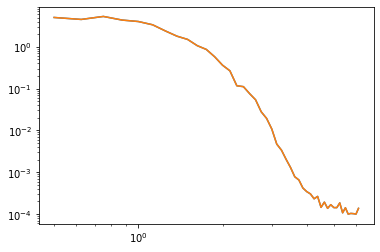

In [ ]:
plt.loglog(masked_k,resid0_spectrum)
plt.loglog(masked_k,resid1_spectrum)


In [ ]:
from scipy.optimize import minimize
from scipy.optimize import curve_fit
def GRF_Loss(x,seed,kwargs0,lens_image,resid0_spectrum):
  fit_Amplitude,fit_Beta=x
  fit_GRF=deepcopy(get_GRF_potential(fit_Amplitude,fit_Beta,seed=seed))

  kwargs_lens_mass_sim = kwargs0['kwargs_lens']+[{'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': fit_GRF}]

  image_sim=lens_image.model(kwargs_lens=kwargs_lens_mass_sim,
                          kwargs_source=kwargs0['kwargs_source'],
                          kwargs_lens_light=kwargs0['kwargs_lens_light'])

  smooth_lens_image,kwargs_true=get_model(kwargs0)
  parameters=get_parameters(kwargs0)
  args1,fisher_matrix1=fit_data(image_sim,smooth_lens_image,parameters)

  kwargs1=parameters.args2kwargs(args1)
  model1=smooth_lens_image.model(kwargs_lens=kwargs1['kwargs_lens'],
                          kwargs_source=kwargs1['kwargs_source'],
                          kwargs_lens_light=kwargs1['kwargs_lens_light'])
  
  resid1=(image_sim-model1)
  resid1_spectrum=compute_radial_spetrum(resid1)

  loss=np.mean(np.power((resid0_spectrum-resid1_spectrum)/resid1_spectrum,2))
  print('loss',loss)
  print('fit_Amplitude',fit_Amplitude)
  print('fit_Beta',fit_Beta)
  return loss

In [ ]:
popt,_ = curve_fit(lambda k,A,beta: A*np.power(k,-beta),masked_k,resid0_spectrum)

In [ ]:
popt

array([2.4328652 , 1.44464997])

In [ ]:

fit_Amplitude=1.2e-4
fit_Beta=1.44
fit_seed=2
bounds=[(1e-5,1),(1e-3,3)]
res=minimize(fun=GRF_Loss,x0=(fit_Amplitude,fit_Beta),args=(fit_seed,kwargs0,lens_image,resid0_spectrum),method='Nelder-Mead',options={'disp':True})

loss 0.14457309985461408
fit_Amplitude 0.00012
fit_Beta 1.44
loss 0.1526725520398226
fit_Amplitude 0.000126
fit_Beta 1.44
loss 0.1320351452707918
fit_Amplitude 0.00012
fit_Beta 1.512
loss 0.12885470105055288
fit_Amplitude 0.000114
fit_Beta 1.512
loss 0.1266674230456235
fit_Amplitude 0.00010800000000000002
fit_Beta 1.548
loss 0.1197585673183501
fit_Amplitude 0.00010800000000000001
fit_Beta 1.62
loss 0.13046968518934968
fit_Amplitude 0.00010200000000000001
fit_Beta 1.71
loss 0.1574688215339689
fit_Amplitude 9.600000000000004e-05
fit_Beta 1.6560000000000001
loss 0.1237796339972141
fit_Amplitude 0.000114
fit_Beta 1.548
loss 0.1143871682881295
fit_Amplitude 0.000114
fit_Beta 1.62
loss 0.10914688351299541
fit_Amplitude 0.00011700000000000002
fit_Beta 1.6560000000000006
loss 0.10649882726439729
fit_Amplitude 0.00011100000000000004
fit_Beta 1.7280000000000006
loss 0.10500428817326254
fit_Amplitude 0.00010950000000000006
fit_Beta 1.8180000000000014
loss 0.08825661277366138
fit_Amplitude 0.00011

In [ ]:
res

 final_simplex: (array([[1.39037758e-04, 2.18225146e+00],
       [1.39041073e-04, 2.18232766e+00],
       [1.39044211e-04, 2.18233766e+00]]), array([0.06714453, 0.06714453, 0.06714453]))
           fun: 0.06714453159581497
       message: 'Optimization terminated successfully.'
          nfev: 69
           nit: 35
        status: 0
       success: True
             x: array([1.39037758e-04, 2.18225146e+00])

In [ ]:
res.x

array([1.39037758e-04, 2.18225146e+00])

In [ ]:
fit_Amplitude,fit_Beta=res.x

In [ ]:
fit_GRF=deepcopy(get_GRF_potential(fit_Amplitude,fit_Beta,seed=fit_seed))

#kwargs_lens_mass_sim = kwargs0['kwargs_lens']+[{'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': fit_GRF}]
kwargs_lens_mass_sim = kwargs0['kwargs_lens']+[{'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': fit_GRF}]

image_sim=lens_image.model(kwargs_lens=kwargs_lens_mass_sim,
                          kwargs_source=kwargs0['kwargs_source'],
                          kwargs_lens_light=kwargs0['kwargs_lens_light'])

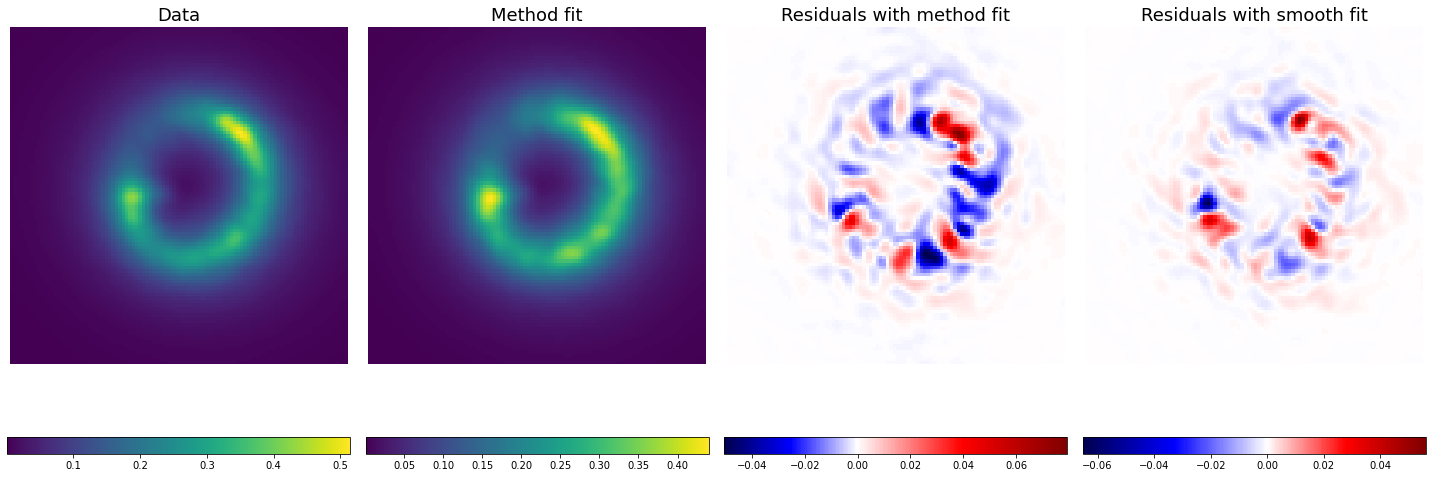

In [ ]:
kwargs0=parameters.args2kwargs(args0)
model0=smooth_lens_image.model(kwargs_lens=kwargs0['kwargs_lens'],
                          kwargs_source=kwargs0['kwargs_source'],
                          kwargs_lens_light=kwargs0['kwargs_lens_light'])

# Plot
fig, ax = plt.subplots(1, 4, figsize=(20, 7))
im0=ax[0].imshow(image, origin='lower')
ax[0].set_title("Data", fontsize=FS)

im1=ax[1].imshow(image_sim, origin='lower')
ax[1].set_title("Method fit", fontsize=FS)

im2=ax[2].imshow((image-image_sim),origin='lower',cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
ax[2].set_title('Residuals with method fit', fontsize=FS)

im3=ax[3].imshow(resid0,origin='lower',cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
ax[3].set_title('Residuals with smooth fit', fontsize=FS)

for i in range(4):
  ax[i].axis('off')

for img, ax in zip((im0, im1, im2,im3), ax):
    fig.colorbar(img, ax=ax,orientation='horizontal')
#fig.colorbar(im, ax=ax[-1])
fig.tight_layout()
plt.show()

In [ ]:
Method_resid_spectrum=compute_radial_spetrum(image-image_sim)

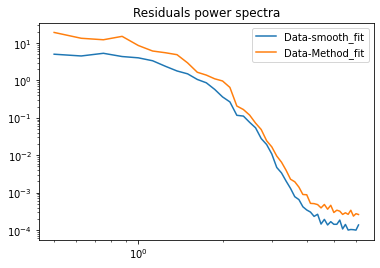

In [ ]:
plt.loglog(masked_k,resid0_spectrum,label='Data-smooth_fit')
plt.loglog(masked_k,Method_resid_spectrum,label='Data-Method_fit')
plt.legend()
plt.title('Residuals power spectra')
plt.show()

In [ ]:
GRF_LensModel=LensModel(['PIXELATED'])


In [ ]:
true_kappa=lens_mass_model.kappa(xgrid,ygrid,kwargs_lens_mass,k=2)*mask
fit_kappa=lens_mass_model.kappa(xgrid,ygrid,kwargs_lens_mass_sim,k=2)*mask

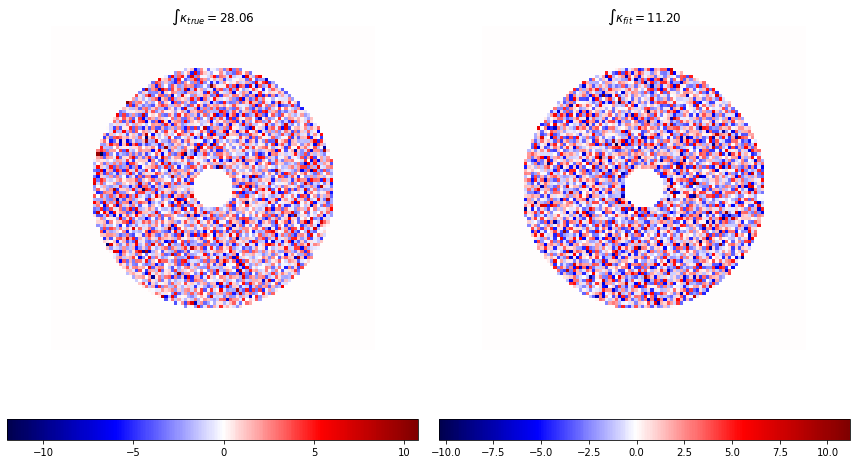

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(12,7))
im0=ax[0].imshow(true_kappa,origin='lower',cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
ax[0].set_title(r'$\int \kappa_{true}=$'+'{:.2f}'.format(true_kappa.sum()))
im1=ax[1].imshow(fit_kappa,origin='lower',cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
ax[1].set_title(r'$\int \kappa_{fit}=$'+'{:.2f}'.format(fit_kappa.sum()))

for i in range(2):
  ax[i].axis('off')

for img, ax in zip((im0, im1), ax):
    fig.colorbar(img, ax=ax,orientation='horizontal')

fig.tight_layout()
plt.show()

#### Large scale perturbations

In [ ]:
# Lens mass
lens_mass_model_list = ['SIE', 'SHEAR','PIXELATED']
lens_mass_model = LensModel(lens_mass_model_list)

GRF_Amp=1e-5
GRF_beta=7
GRF_seed=1
GRF_realisation=deepcopy(get_GRF_potential(GRF_Amp,GRF_beta,seed=GRF_seed))
kwargs_lens_mass = [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},\
                    {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0.0, 'dec_0': 0.0},\
                    {'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': GRF_realisation}]

# Lens light
lens_light_model_list = []
lens_light_model = LightModel(lens_light_model_list)
kwargs_lens_light = [{}]

In [ ]:
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': 0.3}
psf = PSF(**kwargs_psf)

exp_time = 2028
SNR=100

#SNR-defined noise
kwargs_numerics = {'supersampling_factor': 1}
lens_image = LensImage(pixel_grid, psf, noise_class={'background_rms': np.zeros((npix, npix)), 'exposure_time': exp_time},
                         lens_model_class=lens_mass_model,
                         source_model_class=source_light_model,
                         lens_light_model_class=lens_light_model,
                         kwargs_numerics=kwargs_numerics)

image=lens_image.model(kwargs_lens=kwargs_lens_mass,
                          kwargs_source=kwargs_source_light,
                          kwargs_lens_light=kwargs_lens_light)

Peak_signal=np.abs(image).max()
sigma_bkd = Peak_signal/SNR
noise_map = sigma_bkd * np.ones((npix, npix))
noise = Noise(npix, npix, **{'background_rms': sigma_bkd, 'exposure_time': exp_time})

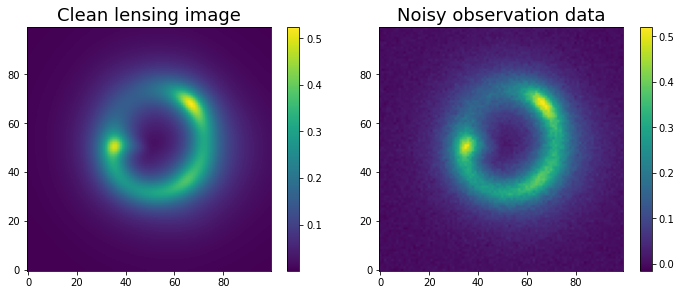

In [ ]:
# Generate a lensed image based on source and lens models
kwargs_numerics = {'supersampling_factor': 1}
lens_image = LensImage(pixel_grid, psf, noise_class=noise,
                         lens_model_class=lens_mass_model,
                         source_model_class=source_light_model,
                         lens_light_model_class=lens_light_model,
                         kwargs_numerics=kwargs_numerics)

image = lens_image.model(kwargs_lens=kwargs_lens_mass,
                          kwargs_source=kwargs_source_light,
                          kwargs_lens_light=kwargs_lens_light)

true_source = lens_image.source_surface_brightness(kwargs_source=kwargs_source_light, 
                                                   de_lensed=True, unconvolved=True)

# Observed noisy data
data = lens_image.simulation(kwargs_lens=kwargs_lens_mass,
                              kwargs_source=kwargs_source_light,
                              kwargs_lens_light=kwargs_lens_light)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
img1 = ax1.imshow(image, origin='lower')
ax1.set_title("Clean lensing image", fontsize=FS)
img2 = ax2.imshow(data, origin='lower')
ax2.set_title("Noisy observation data", fontsize=FS)
for img, ax in zip((img1, img2), (ax1, ax2)):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

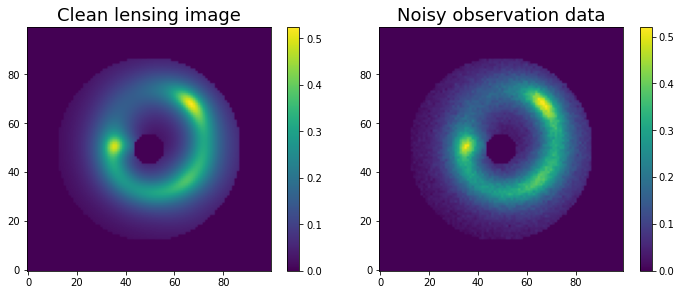

In [ ]:
rmin = 0.5
rmax = 3
radius = np.hypot(xgrid, ygrid)
#Mask covering Einstein ring
mask = ((radius >= rmin) & (radius <= rmax)).astype(bool)

#Account for frequencies present according to size of masked region 
k=np.fft.fftshift(np.fft.fftfreq(mask.shape[0],pix_scl))[image.shape[0]//2:]
mask_spectral_cut_index=np.where(k>1/(rmax-rmin))[0][0]
masked_k=k[mask_spectral_cut_index:]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
img1 = ax1.imshow(image*mask, origin='lower')
ax1.set_title("Clean lensing image", fontsize=FS)
img2 = ax2.imshow(data*mask, origin='lower')
ax2.set_title("Noisy observation data", fontsize=FS)
for img, ax in zip((img1, img2), (ax1, ax2)):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

In [ ]:
kwargs_true={'kwargs_lens':kwargs_lens_mass[:-1],'kwargs_lens_light':kwargs_lens_light,'kwargs_source':kwargs_source_light}

In [ ]:
smooth_lens_image,_=get_model(kwargs_true)
parameters=get_parameters(kwargs_true)
args0,fisher_matrix0=fit_data(image,smooth_lens_image,parameters)

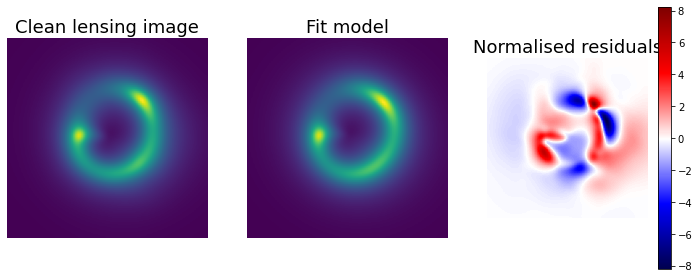

In [ ]:
kwargs0=parameters.args2kwargs(args0)
model0=smooth_lens_image.model(kwargs_lens=kwargs0['kwargs_lens'],
                          kwargs_source=kwargs0['kwargs_source'],
                          kwargs_lens_light=kwargs0['kwargs_lens_light'])

# Plot
fig, ax = plt.subplots(1, 3, figsize=(10, 4))
ax[0].imshow(image, origin='lower')
ax[0].set_title("Clean lensing image", fontsize=FS)

ax[1].imshow(model0, origin='lower')
ax[1].set_title("Fit model", fontsize=FS)

resid0=(image-model0)
im=ax[2].imshow(resid0/sigma_bkd,origin='lower',cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
ax[2].set_title("Normalised residuals", fontsize=FS)

for i in range(3):
  ax[i].axis('off')


fig.colorbar(im, ax=ax[-1])
fig.tight_layout()
plt.show()

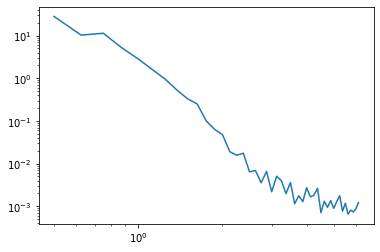

In [ ]:
resid0_spectrum=compute_radial_spetrum(resid0)
plt.loglog(masked_k,resid0_spectrum)

In [ ]:
popt,_ = curve_fit(lambda k,A,beta: A*np.power(k,-beta),masked_k,resid0_spectrum)
popt

array([2.95949733, 3.22344937])

In [ ]:

fit_Amplitude=1.5e-4
fit_Beta=3.223
fit_seed=2
res=minimize(fun=GRF_Loss,x0=(fit_Amplitude,fit_Beta),args=(fit_seed,kwargs0,lens_image,resid0_spectrum),method='Nelder-Mead',options={'disp':True})

loss 9.600370581362137
fit_Amplitude 0.00015
fit_Beta 3.223
loss 8.520936902326943
fit_Amplitude 0.00015749999999999998
fit_Beta 3.223
loss 8.502529424603301
fit_Amplitude 0.00015
fit_Beta 3.38415
loss 7.537408465793293
fit_Amplitude 0.00015749999999999995
fit_Beta 3.38415
loss 6.640770598194323
fit_Amplitude 0.00016124999999999994
fit_Beta 3.4647249999999996
loss 6.446949527374538
fit_Amplitude 0.00015374999999999992
fit_Beta 3.6258749999999997
loss 5.3849995338426
fit_Amplitude 0.00015187499999999988
fit_Beta 3.8273124999999997
loss 4.074965870126445
fit_Amplitude 0.00016312499999999983
fit_Beta 3.9078874999999993
loss 2.592564861272861
fit_Amplitude 0.00016968749999999975
fit_Beta 4.169756249999999
loss 1.6445501457768363
fit_Amplitude 0.0001603124999999997
fit_Beta 4.532343749999999
loss 0.5190326597017159
fit_Amplitude 0.0001598437499999996
fit_Beta 5.066153125
loss 0.32400342333339
fit_Amplitude 0.00017765624999999948
fit_Beta 5.408596874999999
loss 0.6411445332598834
fit_Amplitu

In [ ]:
res.x

array([2.79656255e-06, 8.26039303e+00])

In [ ]:
fit_Amplitude,fit_Beta=res.x
fit_GRF=deepcopy(get_GRF_potential(fit_Amplitude,fit_Beta,seed=fit_seed))

#kwargs_lens_mass_sim = kwargs0['kwargs_lens']+[{'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': fit_GRF}]
kwargs_lens_mass_sim = kwargs0['kwargs_lens']+[{'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': fit_GRF}]

image_sim=lens_image.model(kwargs_lens=kwargs_lens_mass_sim,
                          kwargs_source=kwargs0['kwargs_source'],
                          kwargs_lens_light=kwargs0['kwargs_lens_light'])

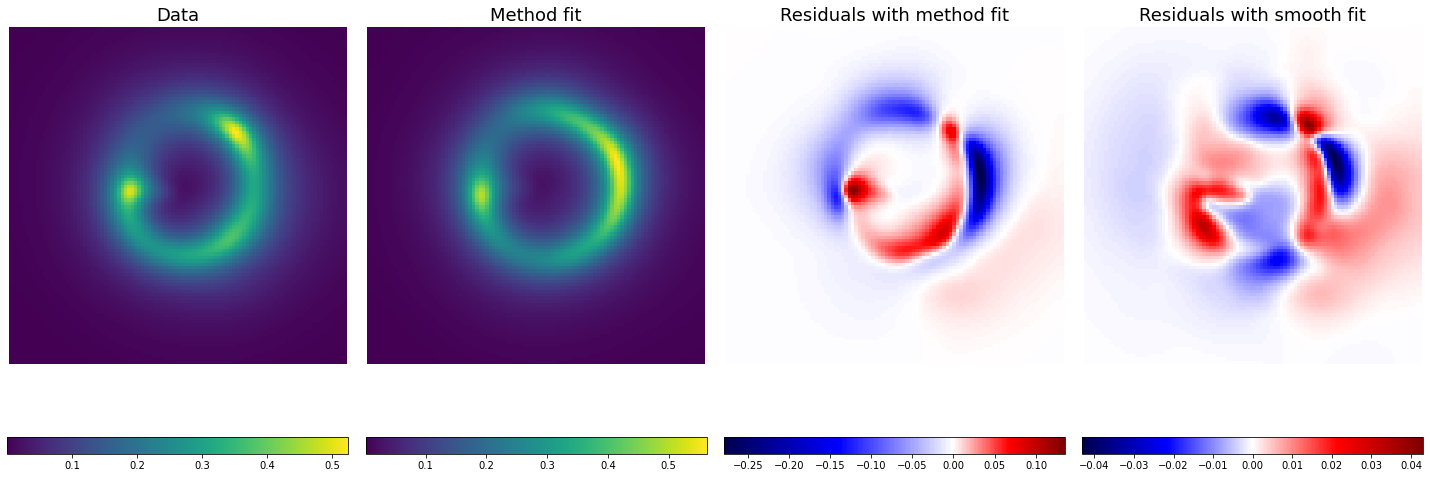

In [ ]:
kwargs0=parameters.args2kwargs(args0)
model0=smooth_lens_image.model(kwargs_lens=kwargs0['kwargs_lens'],
                          kwargs_source=kwargs0['kwargs_source'],
                          kwargs_lens_light=kwargs0['kwargs_lens_light'])

# Plot
fig, ax = plt.subplots(1, 4, figsize=(20, 7))
im0=ax[0].imshow(image, origin='lower')
ax[0].set_title("Data", fontsize=FS)

im1=ax[1].imshow(image_sim, origin='lower')
ax[1].set_title("Method fit", fontsize=FS)

im2=ax[2].imshow((image-image_sim),origin='lower',cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
ax[2].set_title('Residuals with method fit', fontsize=FS)

im3=ax[3].imshow(resid0,origin='lower',cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
ax[3].set_title('Residuals with smooth fit', fontsize=FS)

for i in range(4):
  ax[i].axis('off')

for img, ax in zip((im0, im1, im2,im3), ax):
    fig.colorbar(img, ax=ax,orientation='horizontal')
#fig.colorbar(im, ax=ax[-1])
fig.tight_layout()
plt.show()

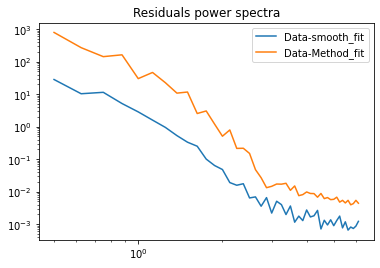

In [ ]:
Method_resid_spectrum=compute_radial_spetrum(image-image_sim)
plt.loglog(masked_k,resid0_spectrum,label='Data-smooth_fit')
plt.loglog(masked_k,Method_resid_spectrum,label='Data-Method_fit')
plt.legend()
plt.title('Residuals power spectra')
plt.show()

In [ ]:
true_kappa=lens_mass_model.kappa(xgrid,ygrid,kwargs_lens_mass,k=2)*mask
fit_kappa=lens_mass_model.kappa(xgrid,ygrid,kwargs_lens_mass_sim,k=2)*mask

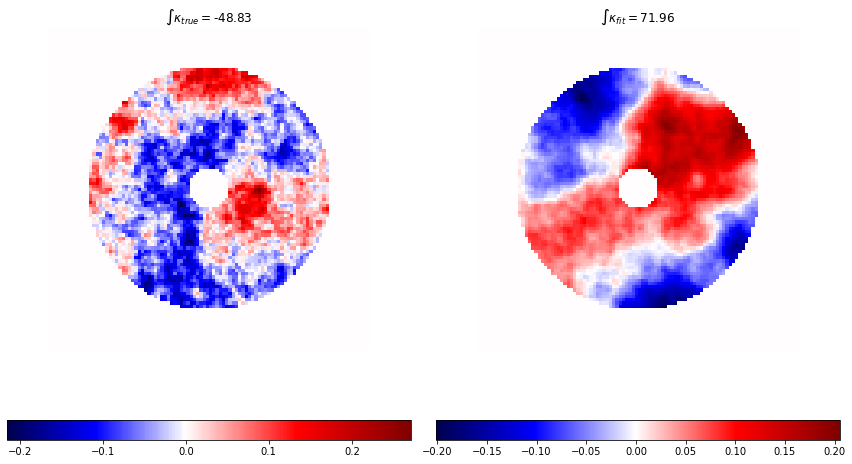

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(12,7))
im0=ax[0].imshow(true_kappa,origin='lower',cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
ax[0].set_title(r'$\int \kappa_{true}=$'+'{:.2f}'.format(true_kappa.sum()))
im1=ax[1].imshow(fit_kappa,origin='lower',cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
ax[1].set_title(r'$\int \kappa_{fit}=$'+'{:.2f}'.format(fit_kappa.sum()))

for i in range(2):
  ax[i].axis('off')

for img, ax in zip((im0, im1), ax):
    fig.colorbar(img, ax=ax,orientation='horizontal')

fig.tight_layout()
plt.show()

## Pixelated source fitting Model for fitting

In [ ]:
# Recreate a Noise object with true noise map
kwargs_noise_fit = {'background_rms': sigma_bkd, 'noise_map': noise_map}
fit_noise = Noise(npix, npix, **kwargs_noise_fit)

# Change only the source light model
fit_source_light_model_list = ['PIXELATED']
kwargs_pixelated_source = {
    'pixel_scale_factor': 0.5, # scaling factor for source pixel size
}
fit_source_light_model = LightModel(fit_source_light_model_list,
                                    kwargs_pixelated=kwargs_pixelated_source)
fit_lens_image = LensImage(pixel_grid, psf, noise_class=fit_noise,
                             lens_model_class=lens_mass_model,
                             source_model_class=fit_source_light_model,
                             lens_light_model_class=lens_light_model,
                             kwargs_numerics=kwargs_numerics)

# 1D coordinate arrays for source grid interpolation
x_coords = fit_lens_image.Grid.pixel_coordinates[0][0, :]
y_coords = fit_lens_image.Grid.pixel_coordinates[1][:, 0]

In [ ]:
kwargs_model = {
    'lens_model_list': lens_mass_model_list,
    'source_model_list': fit_source_light_model_list,
    'lens_light_model_list': lens_light_model_list,
}
kwargs_init = {
    'kwargs_lens': [{'theta_E': 1.5, 'e1': 0.1, 'e2': -0.05, 'center_x': 1e-3, 'center_y': 1e-3}, {'gamma1': -0.02, 'gamma2': 0.02}],
    'kwargs_source': [{'pixels': 1e-8}],
}
kwargs_prior = {
    'kwargs_lens': [{}, {}],
    'kwargs_source': [{}],
}
kwargs_fixed = {
    # we still fix the lens center, because in practice it is constrained by the lens light
    'kwargs_lens': [{'center_x': 0., 'center_y': 0.}, {'ra_0': 0., 'dec_0': 0.}],
    # uncomment the following line to fix all lens parameters
    #'kwargs_lens': kwargs_lens_mass,
    'kwargs_source': [{}],
}
parameters = Parameters(fit_lens_image, kwargs_init, kwargs_prior, kwargs_fixed)
print("num. parameters:", parameters.num_parameters)

num. parameters: 40005


In [ ]:
loss = Loss(data, fit_lens_image, parameters, 
            likelihood_type='l2_norm',
            regularization_terms=['l1_starlet_source', 
                                  'l1_battle_source',
                                  'positivity_source'], 
            regularization_strengths=[(5, 3), 3, 3],
            prior_terms=None)
optimizer = Optimizer(loss, parameters)
print(f"Initial loss: {optimizer.loss(parameters.initial_values()):.2f}")
print("Data points used in likelihood:", loss.likelihood_num_data_points)

Initial loss: 6.09
Data points used in likelihood: 10000


### Optax optimization

In [ ]:
best_fit, logL_best_fit, extra_fields, runtime \
    = optimizer.optax(max_iterations=500, 
                      init_learning_rate=1e-2,
                      restart_from_init=True)
print(f"Runtime: {runtime} s")
print(f"Final loss: {logL_best_fit:.2f}")
kwargs_final = parameters.best_fit_values(as_kwargs=True)

Runtime: 94.08741307258606 s
Final loss: 2.12


/content/drive/My Drive/Jax_Strong_Lensing//Modules/Aymeric_repo/jaxtronomy/Analysis/plot.py:114: UserWarning: True source array has been interpolated to match model array
  warnings.warn("True source array has been interpolated to match model array")


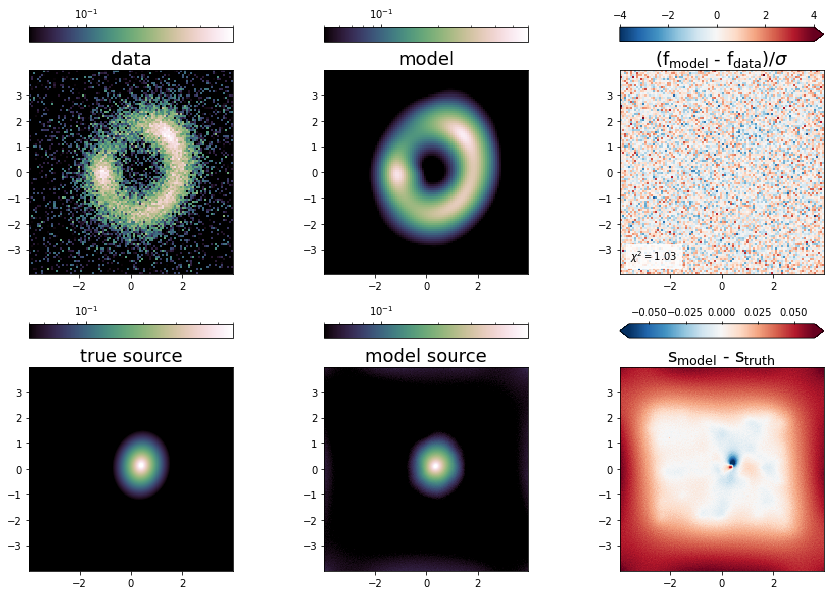

In [ ]:
plotter = Plotter(base_fontsize=FS, flux_vmin=5e-2, flux_vmax=6e-1)
plotter.set_data(data)
plotter.set_true_source(true_source)
plotter.model_summary(fit_lens_image, kwargs_final,
                      likelihood_mask=loss.likelihood_mask)

In [ ]:
def print_errors(kwargs):
    def _print_error(name, value, estimate):
        spaces = " " * (10 - len(name))
        if value != 0:
            error = 100 * abs(value - estimate) / value
            print(name + ":" + spaces + f"{error:.2f} % ({value} => {estimate})")
        else:
            error = abs(value - estimate)
            print(name + ":" + spaces + f"{error:.2f} [abs] ({value} => {estimate})")
    print("Error")
    print("-----")
    for i, params in enumerate(kwargs_lens_mass):
        for key, value in params.items():
            fit = kwargs['kwargs_lens'][i][key]
            _print_error(key, value, fit)
        
print_errors(kwargs_final)

Error
-----
theta_E:   0.14 % (1.6 => 1.6023093467483056)
e1:        32.22 % (0.15 => 0.1016653984586267)
e2:        -77.95 % (-0.04 => -0.008819196707419444)
center_x:  0.00 [abs] (0.0 => 0.0)
center_y:  0.00 [abs] (0.0 => 0.0)
gamma1:    -282.18 % (-0.01 => -0.038217769215582745)
gamma2:    47.91 % (0.03 => 0.044374051739819065)
ra_0:      0.00 [abs] (0.0 => 0.0)
dec_0:     0.00 [abs] (0.0 => 0.0)
